## KGB Model LN Auto V2 With LDA and Variable Reduction

In [2]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Train_Binned_Data_260324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Test_Binned_Data_260324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Oot_Binned_Data_260324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Ttd_Binned_Data_260324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
Train[all_cols].head()

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,319468,Tower,2017-04-13,1.0,1.0,857.0,NaN,0.0,Auto,777.0,789.0,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf

In [9]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [10]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 144))

In [11]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    146855.000000
mean          1.669488
std           0.586060
min           1.060974
50%           1.487468
90%           2.326326
95%           2.722267
99%           3.905550
max          14.347176
Name: wt2, dtype: float64

In [12]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,27867,1.095290,1.583894,8.997074
Bethpage,8328,1.060974,1.453413,5.114712
CPM,6702,1.110488,1.601482,6.383648
GESA,19768,1.101697,1.810696,9.780985
Guardian,19177,1.101219,1.931245,13.497463
HFCU,2044,1.117645,1.662495,8.340647
Hawaii,1438,1.091428,1.775832,8.729644
NCU,595,1.142343,1.784662,5.058578
Numerica,18091,1.096292,1.770058,12.683987


In [13]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [14]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [15]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [16]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(str)]

In [17]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64
bankruptcystatus
[0]     35903
[1]      1132
[2]        84
[-1]        2
Name: count, dtype: int64
bankruptcystatus
[0]     648409
[1]      33203
[2]       3175
[-1]       428
Name: count, dtype: int64


In [18]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [19]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'

In [20]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(146855.0, (146855, 145), 2227.0, 0.015164618160770828)

In [21]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(62938.0, (62938, 145), 959.0, 0.015237217579204931)

In [22]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [23]:
# df_bv= pd.DataFrame()

# for col in req_cols:
#     print(col)
#     ### Train
#     temp_tr= Train.groupby(col).agg(
#         bad_count_tr= ('bad_flag', 'sum'),
#         bad_rate_tr= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_tr= ('p1', 'mean'),
#                                    volume_tr= ('unique_id', 'count')).reset_index()
#     temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
#     temp_tr.insert(0, 'variable', col)
    
#     # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
#     # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
#     ### Test
#     temp_te= Test.groupby(col).agg(
#         bad_count_te= ('bad_flag', 'sum'),
#         bad_rate_te= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_te= ('p1', 'mean'),
#                                   volume_te= ('unique_id', 'count')).reset_index()
#     temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
#     #temp_te['variable']= col
    
#     # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
#     # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
#     # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
#     # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
#     ### Concatenating
#     temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
#     # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
#     temp= Bucket_Order(temp)
#     # display(temp)
    
#     df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
#     del temp, temp_tr, temp_te

In [24]:
# df_bv.head()

In [25]:
# var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
# var_trend_break, len(var_trend_break)

In [26]:
var_trend_break= ['assetpropnewestsaleprice',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'assetpropcurrenttaxtotal',
  'addrcurrenttractratio',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'educationinstitutionprivate',
  'addrinputavmratio60monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'bankruptcycount',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrinputavmvalue12month',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentothercount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(25, 25)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [27]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [28]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [29]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwgfp7y66
  JVM stdout: /tmp/tmpwgfp7y66/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwgfp7y66/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_vn6wb3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [30]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [31]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(146855, 145) (146855, 145) (62938, 145) (62938, 145) (37121, 144) (685215, 144)


(0.015164618160770828, 0.015237217579204931)

In [32]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [33]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (141943, 145)
[1] (3731, 145)
[2] (1178, 145)
[-1] (3, 145)


In [34]:
train_h2o.head(rows= 2)

unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest,wt2
319468,Tower,2017-04-13 00:00:00,1,1,857,nan,0,Auto,777,789,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 

In [35]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 76843.0)","[-inf, 69000.0)","[0.0, inf)",[0],[1],[0],"[242.0, inf)","[-inf, 1.33)","[256476.0, 313290.0)",[0],[1],[0],[1],[1],[0],[0],[0],"[0.0, inf)",[1],"[247.0, inf)",[1],[1],[0],"[-inf, 0.203)",[1],[-1],"[-inf, 0.07

In [36]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [37]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [38]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [39]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

87

In [40]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [41]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id="xgb_auto_wt_segment_with_lda_model",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [ ]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |███████████████████████████████████████████| (done) 100%
CPU times: user 11.3 s, sys: 749 ms, total: 12.1 s
Wall time: 53min 47s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019853209552083414
RMSE: 0.14090141784979815
LogLoss: 0.08877961963581346
Mean Per-Class Error: 0.39704959501672354
AUC: 0.8038248806802077
AUCPR: 0.12179265057366373
Gini: 0.6076497613604155

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0834185855718474
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      232835  7101  0.0296   (7101.0/239936.0)
1      4002    1232  0.7646   (4002.0/5234.0)
Total  236837  8333  0.0453   (11103.0/245170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0834186    0.181708  134
max f2                       0.0485759    0.251465  202
max f0point5                 0.145326     0.185617  71
max accuracy                 0.330645     0.978897  11
max precision                0.660796     1         0
max recall                   0.00126931   1         398
max specificity              0.660796     1         0
max absolute_mcc             0.0557033    0.166004  186
max min_per_class_accuracy   0.0245747    0.721577  278
max mean_per_class_accuracy  0.0245747    0.722996  278
max tns                      0.660796     239937    0
max fns                      0.660796     5222.88   0
max fps                      0.00103261   239937    399
max tps                      0.00126931   5235.24   398
max tnr                      0.660796     1         0
max fnr                      0.660796     0.997639  0
max fpr                      0.00103261   1         399
max tpr                      0.00126931   1         398

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.90 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0116105                   0.134739           9.94685    9.94685            0.226514         0.210739    0.226514                    0.210739            0.115487        0.115487                   894.685   894.685            0.106298
2        0.023542                    0.103213           5.44069    7.66304            0.123898         0.135166    0.174506                    0.172437            0.0649161       0.180404                   444.069   666.304            0.160517
3        0.0351193                   0.0869428          4.89319    6.74994            0.11143          0.110082    0.153713                    0.151881            0.0566496       0.237053                   389.319   574.994            0.20664
4        0.0465138                   0.0782754          3.73407    6.01114            0.085034         0.0984818   0.136888                    0.1388              0.042548        0.279601                   273.407   501.114            0.238519
5        0.0578031                   0.0721139          3.33814    5.48909            0.0760177        0.0902736   0.125                       0.129323            0.0376854       0.317287                   233.814   448.909            0.26553
6        0.113464                    0.050224           2.72134    4.13135            0.0619716        0.0740129   0.0940809                   0.10219             0.151471        0.468758                   172.134   313.135            0.363573
7        0.168205                    0.0359519         

##### Train Predictions

In [41]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [42]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030157,0.660796,0.055164,49035.668531,45812.398032,3223.270498,6.57,20.0,19.09,61.57,42.48
1,0.017742,0.030157,0.023461,49034.498481,47927.430857,1107.067624,2.26,40.0,39.07,82.72,43.65
2,0.008407,0.017742,0.012361,49033.963753,48451.758243,582.205511,1.19,60.0,59.26,93.84,34.58
3,0.004471,0.008407,0.006179,49034.597927,48782.526758,252.071169,0.51,80.0,79.59,98.65,19.06
4,0.000545,0.004471,0.002945,49033.925959,48963.298708,70.627251,0.14,100.0,100.00,100.00,0.00


{'Gini': 55.910000000000004, 'KS': 43.65}


In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030612,0.353437,0.055875,21026.619854,19747.052491,1279.567363,6.09,20.0,19.19,57.66,38.47
1,0.017903,0.030612,0.023641,21026.288533,20501.777680,524.510853,2.49,40.0,39.11,81.29,42.18
2,0.008424,0.017903,0.012426,21025.477359,20774.388195,251.089164,1.19,60.0,59.30,92.61,33.31
3,0.004442,0.008424,0.006174,21026.411444,20911.111384,115.300060,0.55,80.0,79.62,97.80,18.18
4,0.000553,0.004442,0.002926,21025.835135,20977.061994,48.773141,0.23,100.0,100.00,100.00,0.00


{'Gini': 52.86, 'KS': 42.18}


#### Non-weighted

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024056,0.660796,0.044485,29372,28004.0,1368.0,4.66,20.0,19.36,61.43,42.07
1,0.012015,0.024055,0.017727,29370,28893.0,477.0,1.62,40.0,39.34,82.85,43.51
2,0.006407,0.012015,0.008723,29372,29118.0,254.0,0.86,60.0,59.47,94.25,34.78
3,0.003782,0.006407,0.005005,29371,29275.0,96.0,0.33,80.0,79.71,98.56,18.85
4,0.000545,0.003782,0.002593,29370,29338.0,32.0,0.11,100.0,100.00,100.00,0.00


{'Gini': 55.67999999999999, 'KS': 43.51}


In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024140,0.353437,0.044958,12588,12019.0,569.0,4.52,20.0,19.39,59.33,39.94
1,0.012064,0.024139,0.017813,12588,12365.0,223.0,1.77,40.0,39.34,82.59,43.25
2,0.006410,0.012063,0.008728,12587,12493.0,94.0,0.75,60.0,59.50,92.39,32.89
3,0.003743,0.006409,0.004982,12588,12540.0,48.0,0.38,80.0,79.73,97.39,17.66
4,0.000553,0.003743,0.002577,12587,12562.0,25.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 53.5, 'KS': 43.25}


In [43]:
Oot['wt2']= 1
TTD['wt2']= 1

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024096,0.471051,0.044656,7425,7112.0,313.0,4.22,20.0,19.44,57.43,37.99
1,0.012165,0.024096,0.017771,7424,7301.0,123.0,1.66,40.0,39.41,80.00,40.59
2,0.006408,0.012164,0.008806,7424,7357.0,67.0,0.90,60.0,59.52,92.29,32.77
3,0.003760,0.006408,0.004982,7424,7397.0,27.0,0.36,80.0,79.74,97.25,17.51
4,0.000561,0.003760,0.002601,7424,7409.0,15.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 51.54, 'KS': 40.59}


In [ ]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'derogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'addrinputtaxvalue', 'criminalnonfelonycount', 'evictioncount', 'derogcount12month', 'addrinputtimenewest', 'addrprevioustimeoldest', 'educationprogramattended', 'criminalfelonycount', 'educationattendance', 'addrinputlengthofres', 'addrcurrentblockratio', 'addrinputtaxmarketvalue', 'bankruptcydismissed24month', 'addrchangecount03month', 'inquirycollections12month', 'inquirybanking12month', 'bankruptcychapter', 'addrinputsubjectcount', 'addrchangecount24month', 'addrcurrentdeedmailing', 'addrinputdeedmailing', 'addrchangecount06month', 'lienjudgmentcount', 'lienjudgmentsmallclaimscount', 'addrpreviouslengthofres', 'bankruptcystatus', 'assetpropnewestmortgagetype', 'bankruptcycount24month', 'assetproppurchasetimeoldest', 'a

In [ ]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],64166.105469,1.000000,0.187737,assetownership
1,inquiryauto12month.[0],63762.886719,0.993716,0.186557,inquiryauto12month
2,inquiryshortterm12month.[0],26209.839844,0.408469,0.076684,inquiryshortterm12month
3,"sourcenonderogcount12month.[-inf, 2.0)",22840.740234,0.355963,0.066827,sourcenonderogcount12month
4,"assetpropevercount.[-inf, 1.0)",16511.697266,0.257327,0.048310,assetpropevercount
5,inquirytelcom12month.[0],14869.912109,0.231741,0.043506,inquirytelcom12month
6,"sourcenonderogcount.[4.0, 5.0)",8787.505859,0.136949,0.025710,sourcenonderogcount
7,"sourcenonderogcount.[5.0, inf)",7652.057129,0.119254,0.022388,sourcenonderogcount
8,"derogcount.[-inf, 1.0)",7199.679199,0.112204,0.021065,derogcount
9,"addrlastmovetaxratiodiff.[-inf, 0.166)",6199.126953,0.096611,0.018137,addrlastmovetaxratiodiff


## HyperOpt

In [43]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1
# len(col_list)
# 75
col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'derogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'addrinputtaxvalue', 'criminalnonfelonycount', 'evictioncount', 'derogcount12month', 'addrinputtimenewest', 'addrprevioustimeoldest', 'educationprogramattended', 'criminalfelonycount', 'educationattendance', 'addrinputlengthofres', 'addrcurrentblockratio', 'addrinputtaxmarketvalue', 'bankruptcydismissed24month', 'addrchangecount03month', 'inquirycollections12month', 'inquirybanking12month', 'bankruptcychapter', 'addrinputsubjectcount', 'addrchangecount24month', 'addrcurrentdeedmailing', 'addrinputdeedmailing', 'addrchangecount06month', 'lienjudgmentcount', 'lienjudgmentsmallclaimscount', 'addrpreviouslengthofres', 'bankruptcystatus', 'assetpropnewestmortgagetype', 'bankruptcycount24month', 'assetproppurchasetimeoldest', 'assetproppurchasetimenewest', 'criminalnonfelonycount12month', 'assetpersonalcount', 'addrchangecount60month', 'addrinputtimelastsale', 'addrcurrentlengthofres', 'sourcenonderogcount06month', 'subjectrecordtimeoldest', 'assetpropsalepurchaseratio', 'lienjudgmentcourtcount', 'addronfilecollege', 'addrcurrenttimeoldest', 'lienjudgmenttaxcount', 'evictioncount12month', 'businessassociation', 'addrcurrentavmratio12monthprior', 'addrinputsubjectowned', 'sourcecredheadertimeoldest', 'addrinputphoneservice', 'addrinputavmratio12monthprior', 'assetpropcurrentcount', 'addrcurrenttimenewest', 'shorttermloanrequest', 'lienjudgmentdollartotal', 'lienjudgmentcount12month', 'addronfilecount', 'addrinputproblems']
len(col_list)

67

In [44]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [45]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [46]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [47]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrcurrenttaxvalue,addrinputtaxmarketvalue,sourcecredheadertimeoldest,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,addrchangecount24month,addrinputtimelastsale,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,subjectrecordtimeoldest,addrcurrenttimenewest,lienjudgmentdollartotal,addrinputtimenewest,addrcurrenttimelastsale,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalnonfelonycount12month,derogcount12month,educationattendance,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,subjectnewestrecord12month,subjectrecordtimenewest
"[3.0, inf)","[2.0, inf)","[10.0, inf)","[-inf, 510.0)","[-inf, 4900.0)","[176.0, 253.0)","[29.0, 162.0)","[-inf, 23.0)","[113.0, 166.0)","[-inf, 9000.0)","[2.0, inf)","[2.0, inf)","[-inf, 1.0)","[5.0, inf)","[-inf, 518.0)","[-inf, 1.0)",[-1],"[98.0, 166.0)",[-1],"[0.11, 0.71)","[1.0, inf)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)","[683.805, inf)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[1],[0],[0],"[99.0, 165.0)",[-1],[1],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[89.0, 136.0)",[1],[1],"[0.203, inf)",[1],[-1],"[-inf, 0.0742)","[-inf, 117.0)","[-inf, 0.145)","[-inf, 0.028)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[0],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)",[0],[0],"[-inf, 0.00494)","[-inf, 0.000524)",[0],[1],[0],[1],[0],[0],"[0.101, inf)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[0.0643, inf)",[0],[0],[0],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[-inf, 510.0)","[-inf, 4900.0)","[253.0, 353.0)","[239.0, inf)","[87.0, 126.0)","[48.0, 113.0)","[-inf, 9000.0)","[2.0, inf)","[1.0, 2.0)","[1.0, 2.0)","[3.0, 4.0)","[-inf, 518.0)","[-inf, 1.0)",[-1],"[98.0, 166.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)","[-inf, 683.805)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[1],[0],[0],"[99.0, 165.0)","[-inf, 1.33)",[1],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[89.0, 136.0)",[1],[1],"[-inf, 0.203)",[1],[-1],"[-inf, 0.0742)","[117.0, inf)","[0.145, inf)","[0.028, inf)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[1],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)",[0],[0],"[-inf, 0.00494)","[-inf, 0.000524)",[0],[0],[0],[0],[0],[0],"[-inf, 0.101)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[-inf, 0.0643)",[0],[0],[0],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[510.0

In [48]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2, #space['max_depth'] ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id="xgbm_kgb_auto_ln_with_lda_v3",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.1) + ((1-air_ttd['AIR ttd Raceblack'][0])*0.2) + ((1-air_ttd['AIR ttd Racehispanic'][0])*0.2)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [49]:
space = {
    # 'max_depth' : hp.choice('max_depth', range(1, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.1,0.2,0.01),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',1500,4000,50)),    
    'min_child_weight' : hp.quniform('min_child_weight', 130, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1,0.4,0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 0.5, 0.05),
    'reg_lambda': hp.quniform('reg_lambda',5,15,0.25),
    'reg_alpha': hp.quniform('reg_alpha',4,10,0.25),
        'gamma':hp.quniform('gamma',25,50,0.25),
            'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 0.7, 0.05)}

In [50]:
# space = {
#     'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
#     'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
#     'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
#     'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#     'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
#     'gamma':hp.quniform('gamma',5,35,0.5),
#     'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
# #     'seed':42
# }

In [82]:
trials = Trials()

In [ ]:
%%time
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/150 [02:23<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022065,0.022937,0.0042,0.006882,0.014275,0.02694,0.180717


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61643, 'approved_control': 339468}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52648, 'approved_control': 250188}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28868, 'approved_control': 250188}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23780, 'approved_control': 250188}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148880, 'approved_control': 229439}
{'AIR ttd age_cuts': [1.4642], 'AIR ttd Race': [0.7005], 'AIR ttd Raceblack': [0.7311], 'AIR ttd Racehispanic': [0.6667], 'AIR ttd Gender': [0.9322]}
{'loss': 0.1977881330660916, 'status': 'ok', 'KS_diff': 0.5899999999999963, 'train_ks': 39.09, 'test_ks': 39.68, 'gini_diff': 0.5599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021822,0.025589,0.003721,0.006231,0.012963,0.026206,0.31229


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61261, 'approved_control': 339853}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52135, 'approved_control': 251052}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28346, 'approved_control': 251052}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23789, 'approved_control': 251052}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148268, 'approved_control': 230150}
{'AIR ttd age_cuts': [1.4535], 'AIR ttd Race': [0.6914], 'AIR ttd Raceblack': [0.7154], 'AIR ttd Racehispanic': [0.6648], 'AIR ttd Gender': [0.9256]}
{'loss': 0.2023036350070155, 'status': 'ok', 'KS_diff': 0.14999999999999858, 'train_ks': 39.9, 'test_ks': 40.05, 'gini_diff': 1.0300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021794,0.025744,0.002957,0.005862,0.013013,0.026559,0.340606


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61708, 'approved_control': 339310}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52452, 'approved_control': 250588}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28642, 'approved_control': 250588}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23810, 'approved_control': 250588}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148780, 'approved_control': 229546}
{'AIR ttd age_cuts': [1.4664], 'AIR ttd Race': [0.6968], 'AIR ttd Raceblack': [0.7241], 'AIR ttd Racehispanic': [0.6666], 'AIR ttd Gender': [0.9313]}
{'loss': 0.1992360212275031, 'status': 'ok', 'KS_diff': 0.6499999999999986, 'train_ks': 40.17, 'test_ks': 40.82, 'gini_diff': 0.6000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021542,0.006168,0.014721,0.015469,0.018812,0.027586,0.031169


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62750, 'approved_control': 338140}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52207, 'approved_control': 251177}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28265, 'approved_control': 251177}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23942, 'approved_control': 251177}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145273, 'approved_control': 233463}
{'AIR ttd age_cuts': [1.4962], 'AIR ttd Race': [0.692], 'AIR ttd Raceblack': [0.713], 'AIR ttd Racehispanic': [0.6688], 'AIR ttd Gender': [0.894]}
{'loss': 0.2065106665188005, 'status': 'ok', 'KS_diff': 0.2700000000000031, 'train_ks': 34.83, 'test_ks': 35.1, 'gini_diff': 0.06000000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022224,0.025112,0.003424,0.006196,0.012859,0.02727,0.259803


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61050, 'approved_control': 340118}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52486, 'approved_control': 250557}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28828, 'approved_control': 250557}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23658, 'approved_control': 250557}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149308, 'approved_control': 228980}
{'AIR ttd age_cuts': [1.4472], 'AIR ttd Race': [0.6974], 'AIR ttd Raceblack': [0.729], 'AIR ttd Racehispanic': [0.6624], 'AIR ttd Gender': [0.9368]}
{'loss': 0.19907764385133037, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 39.94, 'test_ks': 40.08, 'gini_diff': 0.770000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022388,0.023469,0.004133,0.006698,0.014283,0.027577,0.208105


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61598, 'approved_control': 339497}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52254, 'approved_control': 250861}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28438, 'approved_control': 250861}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23816, 'approved_control': 250861}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148800, 'approved_control': 229565}
{'AIR ttd age_cuts': [1.4631], 'AIR ttd Race': [0.6934], 'AIR ttd Raceblack': [0.7182], 'AIR ttd Racehispanic': [0.6661], 'AIR ttd Gender': [0.9311]}
{'loss': 0.20154556896696696, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 39.11, 'test_ks': 39.22, 'gini_diff': 1.00000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022549,0.023865,0.004288,0.006774,0.013775,0.027405,0.158663


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61064, 'approved_control': 339979}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51665, 'approved_control': 251683}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28406, 'approved_control': 251683}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23259, 'approved_control': 251683}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148370, 'approved_control': 230203}
{'AIR ttd age_cuts': [1.4483], 'AIR ttd Race': [0.6834], 'AIR ttd Raceblack': [0.7151], 'AIR ttd Racehispanic': [0.6484], 'AIR ttd Gender': [0.9259]}
{'loss': 0.20613752555934473, 'status': 'ok', 'KS_diff': 0.14999999999999858, 'train_ks': 39.62, 'test_ks': 39.47, 'gini_diff': 0.50999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022391,0.025527,0.003342,0.006142,0.013145,0.027401,0.262405


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61846, 'approved_control': 339249}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52749, 'approved_control': 250043}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29008, 'approved_control': 250043}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23741, 'approved_control': 250043}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149194, 'approved_control': 229197}
{'AIR ttd age_cuts': [1.4701], 'AIR ttd Race': [0.7023], 'AIR ttd Raceblack': [0.7351], 'AIR ttd Racehispanic': [0.666], 'AIR ttd Gender': [0.9351]}
{'loss': 0.19670266977741044, 'status': 'ok', 'KS_diff': 0.6300000000000026, 'train_ks': 39.8, 'test_ks': 40.43, 'gini_diff': 0.20999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022027,0.0226,0.003947,0.006447,0.013907,0.027837,0.20873


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61363, 'approved_control': 339719}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52217, 'approved_control': 250655}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28413, 'approved_control': 250655}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23804, 'approved_control': 250655}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148793, 'approved_control': 229524}
{'AIR ttd age_cuts': [1.4564], 'AIR ttd Race': [0.6935], 'AIR ttd Raceblack': [0.7182], 'AIR ttd Racehispanic': [0.6663], 'AIR ttd Gender': [0.9314]}
{'loss': 0.2017378530011284, 'status': 'ok', 'KS_diff': 0.23999999999999488, 'train_ks': 39.94, 'test_ks': 39.7, 'gini_diff': 0.9300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021837,0.022527,0.003285,0.006016,0.014075,0.028129,0.188432


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61720, 'approved_control': 339387}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52649, 'approved_control': 250170}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28843, 'approved_control': 250170}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23806, 'approved_control': 250170}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148607, 'approved_control': 229687}
{'AIR ttd age_cuts': [1.4662], 'AIR ttd Race': [0.7006], 'AIR ttd Raceblack': [0.7304], 'AIR ttd Racehispanic': [0.6676], 'AIR ttd Gender': [0.9295]}
{'loss': 0.1978919212207798, 'status': 'ok', 'KS_diff': 0.44999999999999574, 'train_ks': 39.38, 'test_ks': 39.83, 'gini_diff': 0.260000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021879,0.020637,0.005359,0.007777,0.014738,0.027045,0.195424


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61756, 'approved_control': 339371}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52522, 'approved_control': 250575}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28625, 'approved_control': 250575}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23897, 'approved_control': 250575}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149103, 'approved_control': 229228}
{'AIR ttd age_cuts': [1.4674], 'AIR ttd Race': [0.6977], 'AIR ttd Raceblack': [0.7238], 'AIR ttd Racehispanic': [0.6691], 'AIR ttd Gender': [0.9344]}
{'loss': 0.19931502584659855, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 39.99, 'test_ks': 39.58, 'gini_diff': 0.040000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.023015,0.024005,0.004596,0.006969,0.014522,0.028794,0.216416


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61850, 'approved_control': 339255}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52665, 'approved_control': 250518}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28849, 'approved_control': 250518}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23816, 'approved_control': 250518}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148696, 'approved_control': 229749}
{'AIR ttd age_cuts': [1.4701], 'AIR ttd Race': [0.7], 'AIR ttd Raceblack': [0.7295], 'AIR ttd Racehispanic': [0.667], 'AIR ttd Gender': [0.9299]}
{'loss': 0.19835046127448588, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 39.54, 'test_ks': 39.48, 'gini_diff': 0.62000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022524,0.026451,0.003083,0.005546,0.013059,0.027851,0.282329


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60769, 'approved_control': 340431}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52616, 'approved_control': 250680}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28725, 'approved_control': 250680}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23891, 'approved_control': 250680}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148810, 'approved_control': 229543}
{'AIR ttd age_cuts': [1.4393], 'AIR ttd Race': [0.6988], 'AIR ttd Raceblack': [0.726], 'AIR ttd Racehispanic': [0.6687], 'AIR ttd Gender': [0.9314]}
{'loss': 0.19860482561621767, 'status': 'ok', 'KS_diff': 0.010000000000005116, 'train_ks': 39.81, 'test_ks': 39.8, 'gini_diff': 0.540000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022042,0.02692,0.001845,0.005858,0.012654,0.026711,0.347484


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61631, 'approved_control': 339499}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52540, 'approved_control': 250355}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28805, 'approved_control': 250355}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23735, 'approved_control': 250355}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150283, 'approved_control': 227874}
{'AIR ttd age_cuts': [1.4638], 'AIR ttd Race': [0.6987], 'AIR ttd Raceblack': [0.7289], 'AIR ttd Racehispanic': [0.6651], 'AIR ttd Gender': [0.9475]}
{'loss': 0.19838999052517653, 'status': 'ok', 'KS_diff': 0.6999999999999957, 'train_ks': 41.51, 'test_ks': 40.81, 'gini_diff': 2.189999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021568,0.016229,0.006046,0.008953,0.016725,0.028105,0.073439


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61578, 'approved_control': 339517}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56416, 'approved_control': 246356}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30426, 'approved_control': 246356}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25990, 'approved_control': 246356}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148437, 'approved_control': 229606}
{'AIR ttd age_cuts': [1.4623], 'AIR ttd Race': [0.7624], 'AIR ttd Raceblack': [0.7825], 'AIR ttd Racehispanic': [0.7402], 'AIR ttd Gender': [0.9287]}
{'loss': 0.1697900278795177, 'status': 'ok', 'KS_diff': 1.8800000000000026, 'train_ks': 36.47, 'test_ks': 38.35, 'gini_diff': 0.6599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022171,0.024908,0.004157,0.006533,0.013836,0.026564,0.299733


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61804, 'approved_control': 339317}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52218, 'approved_control': 250826}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28311, 'approved_control': 250826}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23907, 'approved_control': 250826}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148733, 'approved_control': 229651}
{'AIR ttd age_cuts': [1.4687], 'AIR ttd Race': [0.6931], 'AIR ttd Raceblack': [0.7151], 'AIR ttd Racehispanic': [0.6686], 'AIR ttd Gender': [0.9305]}
{'loss': 0.20173407376043145, 'status': 'ok', 'KS_diff': 0.06999999999999318, 'train_ks': 40.09, 'test_ks': 40.16, 'gini_diff': 0.86000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022736,0.023483,0.0046,0.007168,0.014098,0.027077,0.133122


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60138, 'approved_control': 340906}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50941, 'approved_control': 252667}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27797, 'approved_control': 252667}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23144, 'approved_control': 252667}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148758, 'approved_control': 229759}
{'AIR ttd age_cuts': [1.4223], 'AIR ttd Race': [0.6712], 'AIR ttd Raceblack': [0.697], 'AIR ttd Racehispanic': [0.6426], 'AIR ttd Gender': [0.9302]}
{'loss': 0.21232571062810313, 'status': 'ok', 'KS_diff': 0.3400000000000034, 'train_ks': 39.58, 'test_ks': 39.92, 'gini_diff': 0.1299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021874,0.02115,0.004391,0.006974,0.014467,0.027566,0.164285


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61284, 'approved_control': 339814}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52725, 'approved_control': 250360}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28837, 'approved_control': 250360}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23888, 'approved_control': 250360}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148771, 'approved_control': 229654}
{'AIR ttd age_cuts': [1.454], 'AIR ttd Race': [0.7012], 'AIR ttd Raceblack': [0.7297], 'AIR ttd Racehispanic': [0.6694], 'AIR ttd Gender': [0.9306]}
{'loss': 0.19771424456155023, 'status': 'ok', 'KS_diff': 0.4099999999999966, 'train_ks': 39.28, 'test_ks': 39.69, 'gini_diff': 0.1600000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02196,0.025145,0.003655,0.006162,0.012604,0.026708,0.27527


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61652, 'approved_control': 339417}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52326, 'approved_control': 250665}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28557, 'approved_control': 250665}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23769, 'approved_control': 250665}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148202, 'approved_control': 230190}
{'AIR ttd age_cuts': [1.4646], 'AIR ttd Race': [0.6949], 'AIR ttd Raceblack': [0.7219], 'AIR ttd Racehispanic': [0.6652], 'AIR ttd Gender': [0.925]}
{'loss': 0.20009356813981483, 'status': 'ok', 'KS_diff': 0.5999999999999943, 'train_ks': 39.52, 'test_ks': 40.12, 'gini_diff': 0.5100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022117,0.021634,0.005041,0.007254,0.015226,0.027049,0.129494


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62419, 'approved_control': 338569}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53198, 'approved_control': 249800}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29338, 'approved_control': 249800}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23860, 'approved_control': 249800}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147768, 'approved_control': 230839}
{'AIR ttd age_cuts': [1.4866], 'AIR ttd Race': [0.7089], 'AIR ttd Raceblack': [0.7441], 'AIR ttd Racehispanic': [0.6701], 'AIR ttd Gender': [0.9197]}
{'loss': 0.1939919204706862, 'status': 'ok', 'KS_diff': 0.4199999999999946, 'train_ks': 38.59, 'test_ks': 39.01, 'gini_diff': 0.6000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021483,0.015918,0.00672,0.009041,0.017343,0.024638,0.077325


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 58717, 'approved_control': 342407}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56472, 'approved_control': 246658}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29223, 'approved_control': 246658}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27249, 'approved_control': 246658}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148172, 'approved_control': 229408}
{'AIR ttd age_cuts': [1.3827], 'AIR ttd Race': [0.7622], 'AIR ttd Raceblack': [0.7507], 'AIR ttd Racehispanic': [0.7751], 'AIR ttd Gender': [0.928]}
{'loss': 0.17000794610716985, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 35.68, 'test_ks': 35.57, 'gini_diff': 0.209999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021506,0.009298,0.010279,0.012756,0.021953,0.02868,0.043453


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59889, 'approved_control': 341095}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54229, 'approved_control': 249097}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29075, 'approved_control': 249097}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25154, 'approved_control': 249097}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144984, 'approved_control': 233440}
{'AIR ttd age_cuts': [1.4156], 'AIR ttd Race': [0.7247], 'AIR ttd Raceblack': [0.7396], 'AIR ttd Racehispanic': [0.7085], 'AIR ttd Gender': [0.8924]}
{'loss': 0.1950580877020757, 'status': 'ok', 'KS_diff': 2.210000000000001, 'train_ks': 34.0, 'test_ks': 36.21, 'gini_diff': 1.380000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021308,0.008318,0.011866,0.013076,0.018981,0.027544,0.040497


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62636, 'approved_control': 338293}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53149, 'approved_control': 250176}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28661, 'approved_control': 250176}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24488, 'approved_control': 250176}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145005, 'approved_control': 233672}
{'AIR ttd age_cuts': [1.4927], 'AIR ttd Race': [0.7073], 'AIR ttd Raceblack': [0.7259], 'AIR ttd Racehispanic': [0.6867], 'AIR ttd Gender': [0.8917]}
{'loss': 0.19673751701804076, 'status': 'ok', 'KS_diff': 0.9499999999999957, 'train_ks': 36.06, 'test_ks': 37.01, 'gini_diff': 0.989999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.020616,0.007526,0.013355,0.013355,0.01797,0.026023,0.034861


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62284, 'approved_control': 338562}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53221, 'approved_control': 249853}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28387, 'approved_control': 249853}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24834, 'approved_control': 249853}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144283, 'approved_control': 234271}
{'AIR ttd age_cuts': [1.4834], 'AIR ttd Race': [0.7091], 'AIR ttd Raceblack': [0.7199], 'AIR ttd Racehispanic': [0.6973], 'AIR ttd Gender': [0.8849]}
{'loss': 0.20060374900822264, 'status': 'ok', 'KS_diff': 0.259999999999998, 'train_ks': 33.84, 'test_ks': 34.1, 'gini_diff': 0.39000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021979,0.020748,0.005357,0.007896,0.016317,0.026329,0.116352


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61643, 'approved_control': 339267}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55001, 'approved_control': 247610}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29585, 'approved_control': 247610}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25416, 'approved_control': 247610}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147791, 'approved_control': 230385}
{'AIR ttd age_cuts': [1.465], 'AIR ttd Race': [0.7395], 'AIR ttd Raceblack': [0.7569], 'AIR ttd Racehispanic': [0.7201], 'AIR ttd Gender': [0.9218]}
{'loss': 0.17846057080667352, 'status': 'ok', 'KS_diff': 1.2600000000000051, 'train_ks': 38.23, 'test_ks': 39.49, 'gini_diff': 1.3599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021762,0.02094,0.004314,0.007108,0.014959,0.027135,0.164868


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61389, 'approved_control': 339744}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52973, 'approved_control': 250211}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29025, 'approved_control': 250211}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23948, 'approved_control': 250211}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148879, 'approved_control': 229474}
{'AIR ttd age_cuts': [1.4571], 'AIR ttd Race': [0.7048], 'AIR ttd Raceblack': [0.7349], 'AIR ttd Racehispanic': [0.6715], 'AIR ttd Gender': [0.9321]}
{'loss': 0.1958039803424315, 'status': 'ok', 'KS_diff': 0.25, 'train_ks': 39.02, 'test_ks': 38.77, 'gini_diff': 0.539999999999992, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022757,0.010826,0.010361,0.012997,0.020453,0.03061,0.049601


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60851, 'approved_control': 340179}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53197, 'approved_control': 250274}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28670, 'approved_control': 250274}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24527, 'approved_control': 250274}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145728, 'approved_control': 232684}
{'AIR ttd age_cuts': [1.4423], 'AIR ttd Race': [0.7075], 'AIR ttd Raceblack': [0.7257], 'AIR ttd Racehispanic': [0.6875], 'AIR ttd Gender': [0.8997]}
{'loss': 0.19890263014765416, 'status': 'ok', 'KS_diff': 1.7899999999999991, 'train_ks': 35.22, 'test_ks': 37.01, 'gini_diff': 0.780000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022352,0.018103,0.0059,0.008401,0.016865,0.028126,0.08695


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61909, 'approved_control': 339196}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56042, 'approved_control': 247095}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30015, 'approved_control': 247095}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26027, 'approved_control': 247095}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146885, 'approved_control': 231437}
{'AIR ttd age_cuts': [1.4718], 'AIR ttd Race': [0.755], 'AIR ttd Raceblack': [0.7696], 'AIR ttd Racehispanic': [0.7389], 'AIR ttd Gender': [0.9118]}
{'loss': 0.17292952901515218, 'status': 'ok', 'KS_diff': 2.280000000000001, 'train_ks': 36.43, 'test_ks': 38.71, 'gini_diff': 1.11999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021429,0.007278,0.01384,0.01384,0.021756,0.025882,0.035776


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62180, 'approved_control': 337867}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53289, 'approved_control': 249403}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28279, 'approved_control': 249403}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25010, 'approved_control': 249403}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144529, 'approved_control': 234030}
{'AIR ttd age_cuts': [1.4838], 'AIR ttd Race': [0.7113], 'AIR ttd Raceblack': [0.7184], 'AIR ttd Racehispanic': [0.7036], 'AIR ttd Gender': [0.8872]}
{'loss': 0.1971592386771398, 'status': 'ok', 'KS_diff': 0.6599999999999966, 'train_ks': 34.09, 'test_ks': 34.75, 'gini_diff': 0.2100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022081,0.020286,0.005216,0.007733,0.016064,0.026891,0.11144


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61564, 'approved_control': 339500}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54261, 'approved_control': 248795}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29418, 'approved_control': 248795}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24843, 'approved_control': 248795}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148389, 'approved_control': 229998}
{'AIR ttd age_cuts': [1.4622], 'AIR ttd Race': [0.726], 'AIR ttd Raceblack': [0.7491], 'AIR ttd Racehispanic': [0.7005], 'AIR ttd Gender': [0.927]}
{'loss': 0.18503488437356352, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 38.81, 'test_ks': 39.13, 'gini_diff': 0.42000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021795,0.024079,0.003683,0.006355,0.013256,0.026302,0.263648


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61727, 'approved_control': 339389}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52566, 'approved_control': 250416}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28580, 'approved_control': 250416}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23986, 'approved_control': 250416}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148705, 'approved_control': 229719}
{'AIR ttd age_cuts': [1.4664], 'AIR ttd Race': [0.6988], 'AIR ttd Raceblack': [0.723], 'AIR ttd Racehispanic': [0.672], 'AIR ttd Gender': [0.93]}
{'loss': 0.19745569290628473, 'status': 'ok', 'KS_diff': 0.9899999999999949, 'train_ks': 39.7, 'test_ks': 40.69, 'gini_diff': 0.36000000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022035,0.017768,0.006406,0.009107,0.01618,0.02583,0.088279


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 58615, 'approved_control': 342568}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56105, 'approved_control': 247506}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29323, 'approved_control': 247506}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26782, 'approved_control': 247506}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147867, 'approved_control': 229918}
{'AIR ttd age_cuts': [1.3796], 'AIR ttd Race': [0.7546], 'AIR ttd Raceblack': [0.7506], 'AIR ttd Racehispanic': [0.7592], 'AIR ttd Gender': [0.9239]}
{'loss': 0.17262267900843226, 'status': 'ok', 'KS_diff': 0.12999999999999545, 'train_ks': 36.34, 'test_ks': 36.47, 'gini_diff': 0.29000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021995,0.022843,0.004876,0.007155,0.013893,0.026553,0.151028


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61299, 'approved_control': 339678}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50998, 'approved_control': 252511}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27916, 'approved_control': 252511}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23082, 'approved_control': 252511}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147499, 'approved_control': 231186}
{'AIR ttd age_cuts': [1.4552], 'AIR ttd Race': [0.6724], 'AIR ttd Raceblack': [0.7004], 'AIR ttd Racehispanic': [0.6413], 'AIR ttd Gender': [0.9165]}
{'loss': 0.21154631079388014, 'status': 'ok', 'KS_diff': 0.09000000000000341, 'train_ks': 39.56, 'test_ks': 39.47, 'gini_diff': 0.01999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021936,0.023328,0.003823,0.006391,0.013604,0.027334,0.222587


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61263, 'approved_control': 339845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52306, 'approved_control': 250749}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28587, 'approved_control': 250749}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23719, 'approved_control': 250749}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148974, 'approved_control': 229353}
{'AIR ttd age_cuts': [1.4535], 'AIR ttd Race': [0.6945], 'AIR ttd Raceblack': [0.7222], 'AIR ttd Racehispanic': [0.6636], 'AIR ttd Gender': [0.9332]}
{'loss': 0.19991107985685025, 'status': 'ok', 'KS_diff': 0.6999999999999957, 'train_ks': 39.27, 'test_ks': 39.97, 'gini_diff': 0.039999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021835,0.007665,0.013706,0.014427,0.018258,0.028485,0.034167


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62420, 'approved_control': 337627}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52927, 'approved_control': 249832}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28191, 'approved_control': 249832}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24736, 'approved_control': 249832}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144010, 'approved_control': 234680}
{'AIR ttd age_cuts': [1.4906], 'AIR ttd Race': [0.7052], 'AIR ttd Raceblack': [0.7148], 'AIR ttd Racehispanic': [0.6945], 'AIR ttd Gender': [0.8816]}
{'loss': 0.2006678221820346, 'status': 'ok', 'KS_diff': 0.7399999999999949, 'train_ks': 33.92, 'test_ks': 34.66, 'gini_diff': 0.3399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022312,0.020503,0.00489,0.007473,0.015819,0.028553,0.110174


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61033, 'approved_control': 340035}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53601, 'approved_control': 249567}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29379, 'approved_control': 249567}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24222, 'approved_control': 249567}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149354, 'approved_control': 228885}
{'AIR ttd age_cuts': [1.4474], 'AIR ttd Race': [0.7149], 'AIR ttd Raceblack': [0.7457], 'AIR ttd Racehispanic': [0.6809], 'AIR ttd Gender': [0.9376]}
{'loss': 0.1907248558237661, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 38.92, 'test_ks': 39.35, 'gini_diff': 0.4500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022002,0.025629,0.00292,0.006229,0.012932,0.02656,0.312427


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61094, 'approved_control': 340044}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52073, 'approved_control': 251178}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28408, 'approved_control': 251178}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23665, 'approved_control': 251178}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149016, 'approved_control': 229341}
{'AIR ttd age_cuts': [1.4488], 'AIR ttd Race': [0.6901], 'AIR ttd Raceblack': [0.7166], 'AIR ttd Racehispanic': [0.6609], 'AIR ttd Gender': [0.9335]}
{'loss': 0.20255667203109887, 'status': 'ok', 'KS_diff': 0.5800000000000054, 'train_ks': 40.81, 'test_ks': 40.23, 'gini_diff': 1.130000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022445,0.0239,0.004047,0.006332,0.013559,0.027673,0.155226


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60951, 'approved_control': 340103}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51775, 'approved_control': 251672}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28454, 'approved_control': 251672}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23321, 'approved_control': 251672}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148484, 'approved_control': 230083}
{'AIR ttd age_cuts': [1.4451], 'AIR ttd Race': [0.6849], 'AIR ttd Raceblack': [0.7164], 'AIR ttd Racehispanic': [0.6501], 'AIR ttd Gender': [0.9272]}
{'loss': 0.20509274124024518, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 39.41, 'test_ks': 39.97, 'gini_diff': 0.170000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021876,0.020914,0.004205,0.006807,0.015111,0.028058,0.155986


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61010, 'approved_control': 340039}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52794, 'approved_control': 250030}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29077, 'approved_control': 250030}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23717, 'approved_control': 250030}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149139, 'approved_control': 229065}
{'AIR ttd age_cuts': [1.4468], 'AIR ttd Race': [0.7029], 'AIR ttd Raceblack': [0.7368], 'AIR ttd Racehispanic': [0.6654], 'AIR ttd Gender': [0.9354]}
{'loss': 0.1959725093018159, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 39.21, 'test_ks': 39.53, 'gini_diff': 0.0099999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021751,0.006792,0.014348,0.015474,0.019375,0.02824,0.033731


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62556, 'approved_control': 338342}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52194, 'approved_control': 251110}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28342, 'approved_control': 251110}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23852, 'approved_control': 251110}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145881, 'approved_control': 232722}
{'AIR ttd age_cuts': [1.4909], 'AIR ttd Race': [0.6919], 'AIR ttd Raceblack': [0.715], 'AIR ttd Racehispanic': [0.6663], 'AIR ttd Gender': [0.9005]}
{'loss': 0.2077026966430282, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 35.43, 'test_ks': 35.89, 'gini_diff': 0.1200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022515,0.021474,0.005054,0.007886,0.015674,0.026963,0.11203


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60939, 'approved_control': 340110}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53578, 'approved_control': 249794}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29175, 'approved_control': 249794}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24403, 'approved_control': 249794}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148726, 'approved_control': 229781}
{'AIR ttd age_cuts': [1.4445], 'AIR ttd Race': [0.714], 'AIR ttd Raceblack': [0.7399], 'AIR ttd Racehispanic': [0.6854], 'AIR ttd Gender': [0.9299]}
{'loss': 0.19107003567429, 'status': 'ok', 'KS_diff': 0.269999999999996, 'train_ks': 39.26, 'test_ks': 38.99, 'gini_diff': 0.00999999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022593,0.024362,0.003953,0.006338,0.013555,0.028284,0.168114


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60804, 'approved_control': 340242}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51496, 'approved_control': 251882}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28108, 'approved_control': 251882}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23388, 'approved_control': 251882}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148403, 'approved_control': 230066}
{'AIR ttd age_cuts': [1.4408], 'AIR ttd Race': [0.6806], 'AIR ttd Raceblack': [0.707], 'AIR ttd Racehispanic': [0.6513], 'AIR ttd Gender': [0.9267]}
{'loss': 0.2074308031492494, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 39.52, 'test_ks': 39.38, 'gini_diff': 0.5200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02248,0.017821,0.005305,0.009122,0.01639,0.029307,0.087607


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60717, 'approved_control': 340422}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 57481, 'approved_control': 245229}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30785, 'approved_control': 245229}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26696, 'approved_control': 245229}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148839, 'approved_control': 228950}
{'AIR ttd age_cuts': [1.4381], 'AIR ttd Race': [0.7804], 'AIR ttd Raceblack': [0.7953], 'AIR ttd Racehispanic': [0.7637], 'AIR ttd Gender': [0.934]}
{'loss': 0.16173783820566184, 'status': 'ok', 'KS_diff': 2.710000000000001, 'train_ks': 34.69, 'test_ks': 37.4, 'gini_diff': 1.5, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022211,0.02632,0.002892,0.005901,0.01288,0.026867,0.328372


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61811, 'approved_control': 339309}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53779, 'approved_control': 249243}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29215, 'approved_control': 249243}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24564, 'approved_control': 249243}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148606, 'approved_control': 229618}
{'AIR ttd age_cuts': [1.4689], 'AIR ttd Race': [0.7184], 'AIR ttd Raceblack': [0.7427], 'AIR ttd Racehispanic': [0.6914], 'AIR ttd Gender': [0.9298]}
{'loss': 0.1873906407886724, 'status': 'ok', 'KS_diff': 0.8600000000000065, 'train_ks': 39.66, 'test_ks': 40.52, 'gini_diff': 0.0300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022246,0.025631,0.00264,0.006027,0.013013,0.027291,0.291374


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61342, 'approved_control': 339774}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53103, 'approved_control': 249625}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29123, 'approved_control': 249625}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23980, 'approved_control': 249625}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149467, 'approved_control': 228696}
{'AIR ttd age_cuts': [1.4557], 'AIR ttd Race': [0.7082], 'AIR ttd Raceblack': [0.7391], 'AIR ttd Racehispanic': [0.674], 'AIR ttd Gender': [0.939]}
{'loss': 0.19277411858642002, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 40.64, 'test_ks': 41.04, 'gini_diff': 0.51999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022251,0.02518,0.003707,0.006305,0.012758,0.027325,0.226345


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61279, 'approved_control': 339828}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52384, 'approved_control': 250951}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28846, 'approved_control': 250951}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23538, 'approved_control': 250951}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148611, 'approved_control': 229836}
{'AIR ttd age_cuts': [1.4539], 'AIR ttd Race': [0.6948], 'AIR ttd Raceblack': [0.7282], 'AIR ttd Racehispanic': [0.6579], 'AIR ttd Gender': [0.9289]}
{'loss': 0.2009329048087367, 'status': 'ok', 'KS_diff': 1.1499999999999986, 'train_ks': 39.91, 'test_ks': 38.76, 'gini_diff': 1.0299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021755,0.026165,0.002808,0.005701,0.012605,0.026207,0.321096


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61618, 'approved_control': 339555}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52848, 'approved_control': 250314}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28837, 'approved_control': 250314}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24011, 'approved_control': 250314}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149349, 'approved_control': 228890}
{'AIR ttd age_cuts': [1.4632], 'AIR ttd Race': [0.7028], 'AIR ttd Raceblack': [0.7298], 'AIR ttd Racehispanic': [0.6729], 'AIR ttd Gender': [0.9374]}
{'loss': 0.19627384925690244, 'status': 'ok', 'KS_diff': 0.269999999999996, 'train_ks': 40.86, 'test_ks': 40.59, 'gini_diff': 1.0599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022449,0.020576,0.004364,0.007373,0.016456,0.028561,0.121837


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61588, 'approved_control': 339414}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54003, 'approved_control': 248871}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29580, 'approved_control': 248871}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24423, 'approved_control': 248871}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148824, 'approved_control': 229437}
{'AIR ttd age_cuts': [1.463], 'AIR ttd Race': [0.7224], 'AIR ttd Raceblack': [0.7529], 'AIR ttd Racehispanic': [0.6884], 'AIR ttd Gender': [0.9319]}
{'loss': 0.18727371401517345, 'status': 'ok', 'KS_diff': 0.6899999999999977, 'train_ks': 38.63, 'test_ks': 39.32, 'gini_diff': 0.4899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022538,0.025427,0.003663,0.006157,0.013267,0.027859,0.262475


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61140, 'approved_control': 339977}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51852, 'approved_control': 251306}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28315, 'approved_control': 251306}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23537, 'approved_control': 251306}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149012, 'approved_control': 229365}
{'AIR ttd age_cuts': [1.4501], 'AIR ttd Race': [0.6868], 'AIR ttd Raceblack': [0.7138], 'AIR ttd Racehispanic': [0.657], 'AIR ttd Gender': [0.9333]}
{'loss': 0.20522442960201454, 'status': 'ok', 'KS_diff': 0.9400000000000048, 'train_ks': 40.2, 'test_ks': 39.26, 'gini_diff': 1.31000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02265,0.017786,0.005859,0.008798,0.01724,0.030178,0.09221


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61665, 'approved_control': 339408}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55252, 'approved_control': 248170}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29362, 'approved_control': 248170}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25890, 'approved_control': 248170}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146477, 'approved_control': 231872}
{'AIR ttd age_cuts': [1.465], 'AIR ttd Race': [0.7413], 'AIR ttd Raceblack': [0.7497], 'AIR ttd Racehispanic': [0.732], 'AIR ttd Gender': [0.9076]}
{'loss': 0.17965952642145652, 'status': 'ok', 'KS_diff': 1.6699999999999946, 'train_ks': 36.77, 'test_ks': 38.44, 'gini_diff': 1.30000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021911,0.025588,0.003011,0.006078,0.012945,0.02648,0.310149


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61807, 'approved_control': 339356}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53624, 'approved_control': 249157}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29231, 'approved_control': 249157}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24393, 'approved_control': 249157}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148929, 'approved_control': 229273}
{'AIR ttd age_cuts': [1.4685], 'AIR ttd Race': [0.7165], 'AIR ttd Raceblack': [0.7433], 'AIR ttd Racehispanic': [0.6869], 'AIR ttd Gender': [0.9331]}
{'loss': 0.188586360087309, 'status': 'ok', 'KS_diff': 1.0399999999999991, 'train_ks': 39.58, 'test_ks': 40.62, 'gini_diff': 0.60999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022543,0.023851,0.003878,0.006466,0.014304,0.028006,0.162261


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61051, 'approved_control': 340004}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52474, 'approved_control': 250991}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28819, 'approved_control': 250991}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23655, 'approved_control': 250991}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148395, 'approved_control': 230147}
{'AIR ttd age_cuts': [1.4477], 'AIR ttd Race': [0.6959], 'AIR ttd Raceblack': [0.7275], 'AIR ttd Racehispanic': [0.6612], 'AIR ttd Gender': [0.9264]}
{'loss': 0.19949085031558894, 'status': 'ok', 'KS_diff': 0.2600000000000051, 'train_ks': 39.58, 'test_ks': 39.84, 'gini_diff': 0.099999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022592,0.022265,0.004583,0.007246,0.015194,0.027392,0.127382


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61381, 'approved_control': 339610}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53026, 'approved_control': 249923}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28982, 'approved_control': 249923}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24044, 'approved_control': 249923}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148838, 'approved_control': 229512}
{'AIR ttd age_cuts': [1.4574], 'AIR ttd Race': [0.7064], 'AIR ttd Raceblack': [0.7346], 'AIR ttd Racehispanic': [0.6749], 'AIR ttd Gender': [0.9317]}
{'loss': 0.1949616002818537, 'status': 'ok', 'KS_diff': 0.28000000000000114, 'train_ks': 38.83, 'test_ks': 38.55, 'gini_diff': 0.079999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021423,0.00863,0.010391,0.013202,0.020286,0.028757,0.04012


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62143, 'approved_control': 338795}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53166, 'approved_control': 250028}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28475, 'approved_control': 250028}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24691, 'approved_control': 250028}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145449, 'approved_control': 233075}
{'AIR ttd age_cuts': [1.4789], 'AIR ttd Race': [0.7079], 'AIR ttd Raceblack': [0.7215], 'AIR ttd Racehispanic': [0.6928], 'AIR ttd Gender': [0.8967]}
{'loss': 0.1994810217582605, 'status': 'ok', 'KS_diff': 0.9299999999999997, 'train_ks': 35.31, 'test_ks': 36.24, 'gini_diff': 1.2599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022326,0.02546,0.002704,0.005954,0.013385,0.027556,0.261487


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60998, 'approved_control': 340141}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52715, 'approved_control': 250289}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28838, 'approved_control': 250289}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23877, 'approved_control': 250289}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149121, 'approved_control': 229131}
{'AIR ttd age_cuts': [1.446], 'AIR ttd Race': [0.7012], 'AIR ttd Raceblack': [0.7301], 'AIR ttd Racehispanic': [0.6693], 'AIR ttd Gender': [0.9351]}
{'loss': 0.19647179617063842, 'status': 'ok', 'KS_diff': 0.7199999999999989, 'train_ks': 40.4, 'test_ks': 41.12, 'gini_diff': 0.52000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021474,0.021037,0.004258,0.007087,0.014694,0.026746,0.169783


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61365, 'approved_control': 339740}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53729, 'approved_control': 248707}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29326, 'approved_control': 248707}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24403, 'approved_control': 248707}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149736, 'approved_control': 228352}
{'AIR ttd age_cuts': [1.4565], 'AIR ttd Race': [0.7192], 'AIR ttd Raceblack': [0.7471], 'AIR ttd Racehispanic': [0.6885], 'AIR ttd Gender': [0.942]}
{'loss': 0.1877254254607671, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 39.87, 'test_ks': 40.3, 'gini_diff': 0.319999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022523,0.024119,0.003846,0.006486,0.013872,0.027818,0.219745


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61268, 'approved_control': 339815}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52119, 'approved_control': 250960}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28253, 'approved_control': 250960}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23866, 'approved_control': 250960}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148209, 'approved_control': 230091}
{'AIR ttd age_cuts': [1.4537], 'AIR ttd Race': [0.6913], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6671], 'AIR ttd Gender': [0.9254]}
{'loss': 0.20165497228325452, 'status': 'ok', 'KS_diff': 0.4200000000000017, 'train_ks': 39.42, 'test_ks': 39.84, 'gini_diff': 0.470000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021682,0.010267,0.009195,0.011717,0.019611,0.030287,0.045406


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61004, 'approved_control': 340071}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54058, 'approved_control': 250091}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29228, 'approved_control': 250091}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24830, 'approved_control': 250091}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146927, 'approved_control': 231512}
{'AIR ttd age_cuts': [1.4464], 'AIR ttd Race': [0.7197], 'AIR ttd Raceblack': [0.7405], 'AIR ttd Racehispanic': [0.6965], 'AIR ttd Gender': [0.9117]}
{'loss': 0.19375006236526351, 'status': 'ok', 'KS_diff': 1.1300000000000026, 'train_ks': 36.16, 'test_ks': 37.29, 'gini_diff': 0.409999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021883,0.024825,0.00335,0.006115,0.012967,0.026466,0.274716


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61649, 'approved_control': 339472}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52773, 'approved_control': 250068}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28584, 'approved_control': 250068}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24189, 'approved_control': 250068}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148616, 'approved_control': 229723}
{'AIR ttd age_cuts': [1.4642], 'AIR ttd Race': [0.7025], 'AIR ttd Raceblack': [0.7241], 'AIR ttd Racehispanic': [0.6786], 'AIR ttd Gender': [0.9294]}
{'loss': 0.19597172661557782, 'status': 'ok', 'KS_diff': 0.45000000000000284, 'train_ks': 39.61, 'test_ks': 40.06, 'gini_diff': 0.15000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022351,0.02086,0.004584,0.007223,0.015789,0.027458,0.108796


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60840, 'approved_control': 340271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54844, 'approved_control': 247963}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29490, 'approved_control': 247963}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25354, 'approved_control': 247963}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148856, 'approved_control': 229221}
{'AIR ttd age_cuts': [1.4417], 'AIR ttd Race': [0.7363], 'AIR ttd Raceblack': [0.7535], 'AIR ttd Racehispanic': [0.7173], 'AIR ttd Gender': [0.933]}
{'loss': 0.18068948014267716, 'status': 'ok', 'KS_diff': 1.6700000000000017, 'train_ks': 38.1, 'test_ks': 39.77, 'gini_diff': 0.85999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021796,0.003809,0.017618,0.017618,0.019606,0.025013,0.02766


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60458, 'approved_control': 340345}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54932, 'approved_control': 247280}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29210, 'approved_control': 247280}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25722, 'approved_control': 247280}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 143520, 'approved_control': 234445}
{'AIR ttd age_cuts': [1.4323], 'AIR ttd Race': [0.7396], 'AIR ttd Raceblack': [0.7485], 'AIR ttd Racehispanic': [0.7297], 'AIR ttd Gender': [0.8794]}
{'loss': 0.18537493485562984, 'status': 'ok', 'KS_diff': 0.44999999999999574, 'train_ks': 32.78, 'test_ks': 33.23, 'gini_diff': 0.11999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022315,0.024598,0.003831,0.006631,0.013681,0.026875,0.241027


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61105, 'approved_control': 339977}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52436, 'approved_control': 250506}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28714, 'approved_control': 250506}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23722, 'approved_control': 250506}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149324, 'approved_control': 229017}
{'AIR ttd age_cuts': [1.4492], 'AIR ttd Race': [0.6969], 'AIR ttd Raceblack': [0.7262], 'AIR ttd Racehispanic': [0.6644], 'AIR ttd Gender': [0.9367]}
{'loss': 0.20026107331668547, 'status': 'ok', 'KS_diff': 0.1600000000000037, 'train_ks': 40.02, 'test_ks': 39.86, 'gini_diff': 0.880000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02216,0.023896,0.003426,0.006136,0.013871,0.027383,0.205129


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60540, 'approved_control': 340578}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53217, 'approved_control': 249920}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28968, 'approved_control': 249920}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24249, 'approved_control': 249920}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149158, 'approved_control': 229076}
{'AIR ttd age_cuts': [1.4333], 'AIR ttd Race': [0.7088], 'AIR ttd Raceblack': [0.7343], 'AIR ttd Racehispanic': [0.6807], 'AIR ttd Gender': [0.9355]}
{'loss': 0.19373906864891394, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 39.51, 'test_ks': 39.65, 'gini_diff': 0.37999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022166,0.022367,0.004145,0.006489,0.014631,0.028462,0.193624


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61617, 'approved_control': 339414}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52472, 'approved_control': 250493}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28695, 'approved_control': 250493}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23777, 'approved_control': 250493}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148575, 'approved_control': 229836}
{'AIR ttd age_cuts': [1.4637], 'AIR ttd Race': [0.6973], 'AIR ttd Raceblack': [0.7257], 'AIR ttd Racehispanic': [0.6659], 'AIR ttd Gender': [0.9287]}
{'loss': 0.1989559999117708, 'status': 'ok', 'KS_diff': 0.5699999999999932, 'train_ks': 39.34, 'test_ks': 39.91, 'gini_diff': 0.5599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02166,0.00999,0.009603,0.011874,0.020038,0.030632,0.039971


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61765, 'approved_control': 339188}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52298, 'approved_control': 251382}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28510, 'approved_control': 251382}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23788, 'approved_control': 251382}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146082, 'approved_control': 232513}
{'AIR ttd age_cuts': [1.4684], 'AIR ttd Race': [0.6926], 'AIR ttd Raceblack': [0.7185], 'AIR ttd Racehispanic': [0.6639], 'AIR ttd Gender': [0.9027]}
{'loss': 0.20972321276858663, 'status': 'ok', 'KS_diff': 0.7000000000000028, 'train_ks': 35.55, 'test_ks': 36.25, 'gini_diff': 0.179999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021822,0.018524,0.006251,0.007866,0.015428,0.026045,0.097584


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60924, 'approved_control': 340118}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56663, 'approved_control': 246344}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29516, 'approved_control': 246344}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27147, 'approved_control': 246344}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148107, 'approved_control': 229672}
{'AIR ttd age_cuts': [1.4442], 'AIR ttd Race': [0.7657], 'AIR ttd Raceblack': [0.7591], 'AIR ttd Racehispanic': [0.7731], 'AIR ttd Gender': [0.9266]}
{'loss': 0.16742302852850433, 'status': 'ok', 'KS_diff': 0.9099999999999966, 'train_ks': 35.63, 'test_ks': 36.54, 'gini_diff': 0.590000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021853,0.020311,0.005367,0.007744,0.01534,0.026056,0.101033


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60802, 'approved_control': 340093}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 58114, 'approved_control': 243411}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30162, 'approved_control': 243411}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27952, 'approved_control': 243411}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148348, 'approved_control': 228955}
{'AIR ttd age_cuts': [1.4416], 'AIR ttd Race': [0.7948], 'AIR ttd Raceblack': [0.7851], 'AIR ttd Racehispanic': [0.8057], 'AIR ttd Gender': [0.9309]}
{'loss': 0.15337361081468828, 'status': 'ok', 'KS_diff': 1.9299999999999997, 'train_ks': 35.5, 'test_ks': 37.43, 'gini_diff': 0.75, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021848,0.022633,0.004952,0.006935,0.015488,0.024476,0.122739


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60359, 'approved_control': 340617}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56287, 'approved_control': 245652}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28987, 'approved_control': 245652}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27300, 'approved_control': 245652}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147549, 'approved_control': 230063}
{'AIR ttd age_cuts': [1.4287], 'AIR ttd Race': [0.7628], 'AIR ttd Raceblack': [0.7476], 'AIR ttd Racehispanic': [0.7797], 'AIR ttd Gender': [0.9213]}
{'loss': 0.16750471348988158, 'status': 'ok', 'KS_diff': 1.3100000000000023, 'train_ks': 36.79, 'test_ks': 38.1, 'gini_diff': 1.25, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022086,0.018381,0.005156,0.007916,0.016397,0.028692,0.089512


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61894, 'approved_control': 339233}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 57395, 'approved_control': 245221}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30455, 'approved_control': 245221}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26940, 'approved_control': 245221}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148036, 'approved_control': 229888}
{'AIR ttd age_cuts': [1.4712], 'AIR ttd Race': [0.7791], 'AIR ttd Raceblack': [0.7868], 'AIR ttd Racehispanic': [0.7708], 'AIR ttd Gender': [0.9252]}
{'loss': 0.16173177445449585, 'status': 'ok', 'KS_diff': 2.030000000000001, 'train_ks': 35.57, 'test_ks': 37.6, 'gini_diff': 1.07000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02218,0.027411,0.003268,0.006171,0.012541,0.026091,0.366986


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61391, 'approved_control': 339753}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52143, 'approved_control': 251171}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28383, 'approved_control': 251171}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23760, 'approved_control': 251171}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148852, 'approved_control': 229531}
{'AIR ttd age_cuts': [1.4568], 'AIR ttd Race': [0.6912], 'AIR ttd Raceblack': [0.716], 'AIR ttd Racehispanic': [0.6637], 'AIR ttd Gender': [0.9316]}
{'loss': 0.20186429287434604, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 40.67, 'test_ks': 40.89, 'gini_diff': 1.109999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021987,0.025178,0.003179,0.006282,0.012805,0.026855,0.238133


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60829, 'approved_control': 340226}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52319, 'approved_control': 250711}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28875, 'approved_control': 250711}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23444, 'approved_control': 250711}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149170, 'approved_control': 229150}
{'AIR ttd age_cuts': [1.4418], 'AIR ttd Race': [0.6948], 'AIR ttd Raceblack': [0.7298], 'AIR ttd Racehispanic': [0.656], 'AIR ttd Gender': [0.9354]}
{'loss': 0.19978688262310348, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 40.34, 'test_ks': 39.78, 'gini_diff': 0.0700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022426,0.017608,0.0059,0.008504,0.017304,0.027163,0.082865


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60057, 'approved_control': 341150}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56655, 'approved_control': 246976}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29589, 'approved_control': 246976}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27066, 'approved_control': 246976}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147827, 'approved_control': 230111}
{'AIR ttd age_cuts': [1.4193], 'AIR ttd Race': [0.7637], 'AIR ttd Raceblack': [0.759], 'AIR ttd Racehispanic': [0.7687], 'AIR ttd Gender': [0.923]}
{'loss': 0.1690157857513105, 'status': 'ok', 'KS_diff': 1.0700000000000003, 'train_ks': 35.42, 'test_ks': 36.49, 'gini_diff': 0.329999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022718,0.025862,0.003556,0.006575,0.013507,0.02716,0.22914


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60655, 'approved_control': 340415}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52190, 'approved_control': 250910}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28846, 'approved_control': 250910}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23344, 'approved_control': 250910}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149205, 'approved_control': 229153}
{'AIR ttd age_cuts': [1.4366], 'AIR ttd Race': [0.6926], 'AIR ttd Raceblack': [0.7284], 'AIR ttd Racehispanic': [0.6527], 'AIR ttd Gender': [0.9354]}
{'loss': 0.20129096323375506, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 40.02, 'test_ks': 39.88, 'gini_diff': 0.28000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022277,0.023167,0.004574,0.007147,0.015152,0.025439,0.163042


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60440, 'approved_control': 340668}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54253, 'approved_control': 248971}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28920, 'approved_control': 248971}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25333, 'approved_control': 248971}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148439, 'approved_control': 229684}
{'AIR ttd age_cuts': [1.4304], 'AIR ttd Race': [0.7254], 'AIR ttd Raceblack': [0.7359], 'AIR ttd Racehispanic': [0.7139], 'AIR ttd Gender': [0.9284]}
{'loss': 0.18485630231416056, 'status': 'ok', 'KS_diff': 0.19000000000000483, 'train_ks': 39.49, 'test_ks': 39.3, 'gini_diff': 0.229999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022413,0.023533,0.00386,0.006475,0.013872,0.028508,0.171086


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60712, 'approved_control': 340370}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51742, 'approved_control': 251820}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28451, 'approved_control': 251820}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23291, 'approved_control': 251820}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148437, 'approved_control': 230192}
{'AIR ttd age_cuts': [1.4381], 'AIR ttd Race': [0.684], 'AIR ttd Raceblack': [0.7158], 'AIR ttd Racehispanic': [0.6488], 'AIR ttd Gender': [0.9264]}
{'loss': 0.20594442840130286, 'status': 'ok', 'KS_diff': 0.2700000000000031, 'train_ks': 39.54, 'test_ks': 39.81, 'gini_diff': 0.25, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022351,0.017817,0.006707,0.008835,0.017967,0.025902,0.083525


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 57790, 'approved_control': 343287}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 57645, 'approved_control': 245159}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29380, 'approved_control': 245159}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 28265, 'approved_control': 245159}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147371, 'approved_control': 229762}
{'AIR ttd age_cuts': [1.3572], 'AIR ttd Race': [0.7828], 'AIR ttd Raceblack': [0.7594], 'AIR ttd Racehispanic': [0.8088], 'AIR ttd Gender': [0.9214]}
{'loss': 0.1595607776896837, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 34.69, 'test_ks': 34.93, 'gini_diff': 0.50000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022181,0.022121,0.005043,0.00761,0.015069,0.025675,0.110944


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61767, 'approved_control': 339105}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 57056, 'approved_control': 244710}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30057, 'approved_control': 244710}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26999, 'approved_control': 244710}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148175, 'approved_control': 229541}
{'AIR ttd age_cuts': [1.4686], 'AIR ttd Race': [0.7761], 'AIR ttd Raceblack': [0.7782], 'AIR ttd Racehispanic': [0.7739], 'AIR ttd Gender': [0.9273]}
{'loss': 0.16191787690297815, 'status': 'ok', 'KS_diff': 1.25, 'train_ks': 36.94, 'test_ks': 38.19, 'gini_diff': 0.7000000000000028, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022051,0.024219,0.003902,0.006902,0.012979,0.026008,0.18602


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61461, 'approved_control': 339650}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52456, 'approved_control': 250906}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29001, 'approved_control': 250906}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23455, 'approved_control': 250906}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148029, 'approved_control': 230531}
{'AIR ttd age_cuts': [1.4589], 'AIR ttd Race': [0.6961], 'AIR ttd Raceblack': [0.7323], 'AIR ttd Racehispanic': [0.6558], 'AIR ttd Gender': [0.9226]}
{'loss': 0.19943339766442597, 'status': 'ok', 'KS_diff': 0.20000000000000284, 'train_ks': 38.89, 'test_ks': 39.09, 'gini_diff': 0.41999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022009,0.016847,0.007076,0.009665,0.017193,0.025834,0.075345


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 57438, 'approved_control': 343413}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 57582, 'approved_control': 245154}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29275, 'approved_control': 245154}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 28307, 'approved_control': 245154}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147749, 'approved_control': 229236}
{'AIR ttd age_cuts': [1.3486], 'AIR ttd Race': [0.782], 'AIR ttd Raceblack': [0.7565], 'AIR ttd Racehispanic': [0.8101], 'AIR ttd Gender': [0.926]}
{'loss': 0.16078725424170634, 'status': 'ok', 'KS_diff': 0.14999999999999858, 'train_ks': 34.22, 'test_ks': 34.37, 'gini_diff': 0.1400000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022388,0.017038,0.007258,0.009114,0.018208,0.026147,0.080088


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 58122, 'approved_control': 342960}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56653, 'approved_control': 246195}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28851, 'approved_control': 246195}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27802, 'approved_control': 246195}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147669, 'approved_control': 229653}
{'AIR ttd age_cuts': [1.3665], 'AIR ttd Race': [0.766], 'AIR ttd Raceblack': [0.7425], 'AIR ttd Racehispanic': [0.7922], 'AIR ttd Gender': [0.9238]}
{'loss': 0.16794528373564105, 'status': 'ok', 'KS_diff': 0.5100000000000051, 'train_ks': 35.13, 'test_ks': 34.62, 'gini_diff': 0.4500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021722,0.023393,0.003988,0.006736,0.013462,0.025938,0.172289


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60520, 'approved_control': 340381}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51763, 'approved_control': 251281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28526, 'approved_control': 251281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23237, 'approved_control': 251281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148587, 'approved_control': 229886}
{'AIR ttd age_cuts': [1.4337], 'AIR ttd Race': [0.6858], 'AIR ttd Raceblack': [0.7192], 'AIR ttd Racehispanic': [0.6488], 'AIR ttd Gender': [0.9286]}
{'loss': 0.20458036327605814, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 39.93, 'test_ks': 39.99, 'gini_diff': 0.1400000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022908,0.023537,0.004142,0.006781,0.015832,0.027138,0.151785


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61898, 'approved_control': 339207}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55546, 'approved_control': 247489}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29555, 'approved_control': 247489}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25991, 'approved_control': 247489}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147510, 'approved_control': 230642}
{'AIR ttd age_cuts': [1.4712], 'AIR ttd Race': [0.7472], 'AIR ttd Raceblack': [0.7565], 'AIR ttd Racehispanic': [0.7367], 'AIR ttd Gender': [0.9189]}
{'loss': 0.17499240306132774, 'status': 'ok', 'KS_diff': 1.6499999999999986, 'train_ks': 38.24, 'test_ks': 39.89, 'gini_diff': 0.830000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021987,0.025084,0.003075,0.005947,0.012738,0.027139,0.201964


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60678, 'approved_control': 340358}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51864, 'approved_control': 251331}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28545, 'approved_control': 251331}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23319, 'approved_control': 251331}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148795, 'approved_control': 229631}
{'AIR ttd age_cuts': [1.4374], 'AIR ttd Race': [0.6869], 'AIR ttd Raceblack': [0.7197], 'AIR ttd Racehispanic': [0.651], 'AIR ttd Gender': [0.931]}
{'loss': 0.20392065472274426, 'status': 'ok', 'KS_diff': 0.1599999999999966, 'train_ks': 39.83, 'test_ks': 39.67, 'gini_diff': 0.14000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021987,0.010469,0.010047,0.012515,0.018478,0.031066,0.04805


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61248, 'approved_control': 339733}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53553, 'approved_control': 249680}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28693, 'approved_control': 249680}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24860, 'approved_control': 249680}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145644, 'approved_control': 232831}
{'AIR ttd age_cuts': [1.4537], 'AIR ttd Race': [0.714], 'AIR ttd Raceblack': [0.728], 'AIR ttd Racehispanic': [0.6985], 'AIR ttd Gender': [0.8987]}
{'loss': 0.19592587269493542, 'status': 'ok', 'KS_diff': 1.1599999999999966, 'train_ks': 35.27, 'test_ks': 36.43, 'gini_diff': 1.54000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.0225,0.024274,0.004312,0.006634,0.0139,0.027473,0.169825


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60738, 'approved_control': 340232}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51251, 'approved_control': 251950}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28110, 'approved_control': 251950}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23141, 'approved_control': 251950}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147848, 'approved_control': 230688}
{'AIR ttd age_cuts': [1.4394], 'AIR ttd Race': [0.6773], 'AIR ttd Raceblack': [0.7069], 'AIR ttd Racehispanic': [0.6443], 'AIR ttd Gender': [0.9207]}
{'loss': 0.20930871377789995, 'status': 'ok', 'KS_diff': 0.4200000000000017, 'train_ks': 39.28, 'test_ks': 39.7, 'gini_diff': 0.2600000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022408,0.016857,0.00678,0.008978,0.017635,0.025859,0.076847


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59073, 'approved_control': 342175}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55098, 'approved_control': 249588}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28632, 'approved_control': 249588}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26466, 'approved_control': 249588}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147866, 'approved_control': 230256}
{'AIR ttd age_cuts': [1.3922], 'AIR ttd Race': [0.7349], 'AIR ttd Raceblack': [0.7268], 'AIR ttd Racehispanic': [0.7439], 'AIR ttd Gender': [0.9225]}
{'loss': 0.18350127282969037, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 35.25, 'test_ks': 35.31, 'gini_diff': 0.3299999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022125,0.022654,0.004738,0.00705,0.015087,0.02618,0.13109


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60862, 'approved_control': 340215}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54649, 'approved_control': 248408}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29240, 'approved_control': 248408}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25409, 'approved_control': 248408}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148242, 'approved_control': 229867}
{'AIR ttd age_cuts': [1.4425], 'AIR ttd Race': [0.7324], 'AIR ttd Raceblack': [0.7458], 'AIR ttd Racehispanic': [0.7175], 'AIR ttd Gender': [0.9265]}
{'loss': 0.18200013638534832, 'status': 'ok', 'KS_diff': 0.7399999999999949, 'train_ks': 38.59, 'test_ks': 39.33, 'gini_diff': 0.910000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021935,0.023389,0.004006,0.006742,0.013686,0.026006,0.167408


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61004, 'approved_control': 340059}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52132, 'approved_control': 251418}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28653, 'approved_control': 251418}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23479, 'approved_control': 251418}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148241, 'approved_control': 230408}
{'AIR ttd age_cuts': [1.4464], 'AIR ttd Race': [0.6903], 'AIR ttd Raceblack': [0.7219], 'AIR ttd Racehispanic': [0.6552], 'AIR ttd Gender': [0.9244]}
{'loss': 0.2031040535875283, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 39.31, 'test_ks': 39.4, 'gini_diff': 0.40999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021815,0.017223,0.006754,0.009328,0.016829,0.024793,0.07914


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 57969, 'approved_control': 343255}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 57177, 'approved_control': 245878}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29366, 'approved_control': 245878}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27811, 'approved_control': 245878}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147788, 'approved_control': 229461}
{'AIR ttd age_cuts': [1.3617], 'AIR ttd Race': [0.7742], 'AIR ttd Raceblack': [0.7566], 'AIR ttd Racehispanic': [0.7935], 'AIR ttd Gender': [0.9252]}
{'loss': 0.1640397525340819, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 35.79, 'test_ks': 35.7, 'gini_diff': 0.05999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022463,0.021472,0.0051,0.00755,0.016131,0.026585,0.115623


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61438, 'approved_control': 339600}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54787, 'approved_control': 248133}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28608, 'approved_control': 248133}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26179, 'approved_control': 248133}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147135, 'approved_control': 231032}
{'AIR ttd age_cuts': [1.4587], 'AIR ttd Race': [0.7351], 'AIR ttd Raceblack': [0.7304], 'AIR ttd Racehispanic': [0.74], 'AIR ttd Gender': [0.9149]}
{'loss': 0.18178844761331153, 'status': 'ok', 'KS_diff': 2.0799999999999983, 'train_ks': 36.92, 'test_ks': 39.0, 'gini_diff': 1.25, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022121,0.024565,0.003564,0.006341,0.012784,0.0268,0.192325


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61354, 'approved_control': 339684}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51645, 'approved_control': 251808}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28455, 'approved_control': 251808}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23190, 'approved_control': 251808}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147852, 'approved_control': 230816}
{'AIR ttd age_cuts': [1.4562], 'AIR ttd Race': [0.6828], 'AIR ttd Raceblack': [0.7159], 'AIR ttd Racehispanic': [0.646], 'AIR ttd Gender': [0.9203]}
{'loss': 0.2063889926580785, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 39.89, 'test_ks': 39.49, 'gini_diff': 0.23999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021881,0.011809,0.009224,0.011478,0.019689,0.029132,0.058619


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59055, 'approved_control': 342026}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55495, 'approved_control': 248401}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29475, 'approved_control': 248401}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26020, 'approved_control': 248401}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145550, 'approved_control': 232649}
{'AIR ttd age_cuts': [1.3921], 'AIR ttd Race': [0.7439], 'AIR ttd Raceblack': [0.7518], 'AIR ttd Racehispanic': [0.7348], 'AIR ttd Gender': [0.8987]}
{'loss': 0.18051796458155708, 'status': 'ok', 'KS_diff': 1.7700000000000031, 'train_ks': 34.37, 'test_ks': 36.14, 'gini_diff': 0.839999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022696,0.024331,0.003921,0.006351,0.014525,0.028691,0.20023


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61356, 'approved_control': 339742}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52758, 'approved_control': 250763}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28877, 'approved_control': 250763}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23881, 'approved_control': 250763}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148760, 'approved_control': 229721}
{'AIR ttd age_cuts': [1.4564], 'AIR ttd Race': [0.7004], 'AIR ttd Raceblack': [0.7295], 'AIR ttd Racehispanic': [0.6681], 'AIR ttd Gender': [0.9303]}
{'loss': 0.19770959824237333, 'status': 'ok', 'KS_diff': 0.12000000000000455, 'train_ks': 39.62, 'test_ks': 39.74, 'gini_diff': 0.39999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022203,0.024126,0.00379,0.006073,0.01353,0.027697,0.182879


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61143, 'approved_control': 339955}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52496, 'approved_control': 250712}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28708, 'approved_control': 250712}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23788, 'approved_control': 250712}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148328, 'approved_control': 230194}
{'AIR ttd age_cuts': [1.4501], 'AIR ttd Race': [0.6971], 'AIR ttd Raceblack': [0.7254], 'AIR ttd Racehispanic': [0.6657], 'AIR ttd Gender': [0.9258]}
{'loss': 0.1987770561172812, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 39.29, 'test_ks': 39.35, 'gini_diff': 0.00999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02215,0.025967,0.003061,0.00634,0.012905,0.02656,0.313551


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61528, 'approved_control': 339606}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52001, 'approved_control': 251180}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28487, 'approved_control': 251180}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23514, 'approved_control': 251180}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148811, 'approved_control': 229641}
{'AIR ttd age_cuts': [1.4608], 'AIR ttd Race': [0.6892], 'AIR ttd Raceblack': [0.7186], 'AIR ttd Racehispanic': [0.6568], 'AIR ttd Gender': [0.931]}
{'loss': 0.20291319334663938, 'status': 'ok', 'KS_diff': 0.020000000000003126, 'train_ks': 40.71, 'test_ks': 40.69, 'gini_diff': 1.14000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022283,0.027539,0.003252,0.006067,0.013008,0.026414,0.393123


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61195, 'approved_control': 339903}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51769, 'approved_control': 251115}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28227, 'approved_control': 251115}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23542, 'approved_control': 251115}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148841, 'approved_control': 229387}
{'AIR ttd age_cuts': [1.4516], 'AIR ttd Race': [0.6862], 'AIR ttd Raceblack': [0.7121], 'AIR ttd Racehispanic': [0.6576], 'AIR ttd Gender': [0.9322]}
{'loss': 0.2054595430586161, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 40.67, 'test_ks': 40.59, 'gini_diff': 1.5200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022247,0.021888,0.004932,0.007274,0.015668,0.026238,0.127952


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61496, 'approved_control': 339603}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55478, 'approved_control': 247612}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29269, 'approved_control': 247612}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26209, 'approved_control': 247612}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147151, 'approved_control': 230949}
{'AIR ttd age_cuts': [1.4601], 'AIR ttd Race': [0.7459], 'AIR ttd Raceblack': [0.7488], 'AIR ttd Racehispanic': [0.7426], 'AIR ttd Gender': [0.9153]}
{'loss': 0.17565309125110234, 'status': 'ok', 'KS_diff': 0.6799999999999997, 'train_ks': 37.92, 'test_ks': 38.6, 'gini_diff': 0.6799999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022265,0.025653,0.002775,0.00596,0.012966,0.027843,0.301301


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61541, 'approved_control': 339579}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51791, 'approved_control': 251482}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28389, 'approved_control': 251482}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23402, 'approved_control': 251482}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149042, 'approved_control': 229401}
{'AIR ttd age_cuts': [1.4612], 'AIR ttd Race': [0.6856], 'AIR ttd Raceblack': [0.7152], 'AIR ttd Racehispanic': [0.6529], 'AIR ttd Gender': [0.9335]}
{'loss': 0.20484663153489824, 'status': 'ok', 'KS_diff': 0.11999999999999744, 'train_ks': 40.69, 'test_ks': 40.57, 'gini_diff': 1.15999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022078,0.02196,0.005026,0.007622,0.014854,0.026059,0.128867


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60518, 'approved_control': 340579}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54890, 'approved_control': 248409}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28516, 'approved_control': 248409}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26374, 'approved_control': 248409}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148061, 'approved_control': 229981}
{'AIR ttd age_cuts': [1.4327], 'AIR ttd Race': [0.7355], 'AIR ttd Raceblack': [0.7273], 'AIR ttd Racehispanic': [0.7448], 'AIR ttd Gender': [0.9249]}
{'loss': 0.1810957446660568, 'status': 'ok', 'KS_diff': 1.2299999999999969, 'train_ks': 37.17, 'test_ks': 38.4, 'gini_diff': 1.16000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021983,0.02427,0.003951,0.006499,0.01271,0.026531,0.188151


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61218, 'approved_control': 339883}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52093, 'approved_control': 251239}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28735, 'approved_control': 251239}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23358, 'approved_control': 251239}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148501, 'approved_control': 230029}
{'AIR ttd age_cuts': [1.4522], 'AIR ttd Race': [0.6902], 'AIR ttd Raceblack': [0.7246], 'AIR ttd Racehispanic': [0.6523], 'AIR ttd Gender': [0.9275]}
{'loss': 0.2024639799357122, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 39.38, 'test_ks': 39.34, 'gini_diff': 0.270000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022437,0.022984,0.005533,0.007766,0.014098,0.026153,0.168336


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61755, 'approved_control': 339327}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52398, 'approved_control': 251144}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28833, 'approved_control': 251144}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23565, 'approved_control': 251144}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148133, 'approved_control': 230515}
{'AIR ttd age_cuts': [1.4672], 'AIR ttd Race': [0.6946], 'AIR ttd Raceblack': [0.7273], 'AIR ttd Racehispanic': [0.6582], 'AIR ttd Gender': [0.9233]}
{'loss': 0.20142690503320426, 'status': 'ok', 'KS_diff': 0.00999999999999801, 'train_ks': 38.91, 'test_ks': 38.9, 'gini_diff': 0.090000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022449,0.022493,0.004237,0.006644,0.015472,0.027406,0.139385


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61769, 'approved_control': 339315}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53938, 'approved_control': 249118}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29459, 'approved_control': 249118}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24479, 'approved_control': 249118}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149113, 'approved_control': 229276}
{'AIR ttd age_cuts': [1.4678], 'AIR ttd Race': [0.7208], 'AIR ttd Raceblack': [0.7493], 'AIR ttd Racehispanic': [0.6893], 'AIR ttd Gender': [0.9343]}
{'loss': 0.18755509831414297, 'status': 'ok', 'KS_diff': 0.8199999999999932, 'train_ks': 39.34, 'test_ks': 40.16, 'gini_diff': 0.439999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021879,0.00839,0.013013,0.01431,0.018751,0.027328,0.03913


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62514, 'approved_control': 338400}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52359, 'approved_control': 250837}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28387, 'approved_control': 250837}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23972, 'approved_control': 250837}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146488, 'approved_control': 232067}
{'AIR ttd age_cuts': [1.4896], 'AIR ttd Race': [0.6948], 'AIR ttd Raceblack': [0.717], 'AIR ttd Racehispanic': [0.6704], 'AIR ttd Gender': [0.907]}
{'loss': 0.2053789239683844, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 35.39, 'test_ks': 35.89, 'gini_diff': 0.3299999999999983, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022703,0.024994,0.004031,0.006759,0.013363,0.027954,0.25792


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61428, 'approved_control': 339696}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52024, 'approved_control': 251130}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28413, 'approved_control': 251130}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23611, 'approved_control': 251130}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148701, 'approved_control': 229690}
{'AIR ttd age_cuts': [1.458], 'AIR ttd Race': [0.6896], 'AIR ttd Raceblack': [0.7168], 'AIR ttd Racehispanic': [0.6596], 'AIR ttd Gender': [0.9302]}
{'loss': 0.20291557139162414, 'status': 'ok', 'KS_diff': 0.28000000000000114, 'train_ks': 39.42, 'test_ks': 39.7, 'gini_diff': 0.6700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022465,0.022998,0.004434,0.006892,0.014459,0.028062,0.210062


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61201, 'approved_control': 339910}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52079, 'approved_control': 250995}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28430, 'approved_control': 250995}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23649, 'approved_control': 250995}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149318, 'approved_control': 229082}
{'AIR ttd age_cuts': [1.4518], 'AIR ttd Race': [0.6907], 'AIR ttd Raceblack': [0.7176], 'AIR ttd Racehispanic': [0.661], 'AIR ttd Gender': [0.9363]}
{'loss': 0.20241511895895495, 'status': 'ok', 'KS_diff': 0.5599999999999952, 'train_ks': 39.88, 'test_ks': 40.44, 'gini_diff': 0.5500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022379,0.024577,0.003663,0.006379,0.01358,0.027258,0.240515


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61373, 'approved_control': 339765}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52646, 'approved_control': 250449}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28720, 'approved_control': 250449}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23926, 'approved_control': 250449}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148223, 'approved_control': 230194}
{'AIR ttd age_cuts': [1.4564], 'AIR ttd Race': [0.6998], 'AIR ttd Raceblack': [0.7264], 'AIR ttd Racehispanic': [0.6702], 'AIR ttd Gender': [0.9251]}
{'loss': 0.19754342119020102, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 39.38, 'test_ks': 39.46, 'gini_diff': 1.149999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02238,0.02325,0.00478,0.00728,0.013995,0.026946,0.163889


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60513, 'approved_control': 340504}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51748, 'approved_control': 251381}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28495, 'approved_control': 251381}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23253, 'approved_control': 251381}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148259, 'approved_control': 230287}
{'AIR ttd age_cuts': [1.433], 'AIR ttd Race': [0.6852], 'AIR ttd Raceblack': [0.7181], 'AIR ttd Racehispanic': [0.649], 'AIR ttd Gender': [0.925]}
{'loss': 0.2051986603949683, 'status': 'ok', 'KS_diff': 0.0800000000000054, 'train_ks': 39.87, 'test_ks': 39.95, 'gini_diff': 0.5199999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02254,0.017499,0.006236,0.00881,0.017768,0.027082,0.0765


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59379, 'approved_control': 341875}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56761, 'approved_control': 247056}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29612, 'approved_control': 247056}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27149, 'approved_control': 247056}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147159, 'approved_control': 230550}
{'AIR ttd age_cuts': [1.4003], 'AIR ttd Race': [0.7648], 'AIR ttd Raceblack': [0.7594], 'AIR ttd Racehispanic': [0.7709], 'AIR ttd Gender': [0.917]}
{'loss': 0.16864591688175706, 'status': 'ok', 'KS_diff': 0.18999999999999773, 'train_ks': 35.4, 'test_ks': 35.21, 'gini_diff': 0.1700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021142,0.019743,0.005373,0.007472,0.014999,0.024483,0.103896


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61295, 'approved_control': 339741}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56101, 'approved_control': 246272}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29824, 'approved_control': 246272}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26277, 'approved_control': 246272}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148610, 'approved_control': 229225}
{'AIR ttd age_cuts': [1.4547], 'AIR ttd Race': [0.7584], 'AIR ttd Raceblack': [0.7672], 'AIR ttd Racehispanic': [0.7485], 'AIR ttd Gender': [0.9315]}
{'loss': 0.17043936492232245, 'status': 'ok', 'KS_diff': 2.0799999999999983, 'train_ks': 37.08, 'test_ks': 39.16, 'gini_diff': 1.119999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021939,0.020282,0.005733,0.007869,0.016787,0.026041,0.105654


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61199, 'approved_control': 339876}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54907, 'approved_control': 248244}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29152, 'approved_control': 248244}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25755, 'approved_control': 248244}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147995, 'approved_control': 230122}
{'AIR ttd age_cuts': [1.4518], 'AIR ttd Race': [0.7364], 'AIR ttd Raceblack': [0.744], 'AIR ttd Racehispanic': [0.7278], 'AIR ttd Gender': [0.924]}
{'loss': 0.18081027082205509, 'status': 'ok', 'KS_diff': 0.7100000000000009, 'train_ks': 38.37, 'test_ks': 39.08, 'gini_diff': 0.14000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02241,0.020266,0.006369,0.008517,0.016961,0.026039,0.115583


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60992, 'approved_control': 340066}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53079, 'approved_control': 250439}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28631, 'approved_control': 250439}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24448, 'approved_control': 250439}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149080, 'approved_control': 229333}
{'AIR ttd age_cuts': [1.446], 'AIR ttd Race': [0.7056], 'AIR ttd Raceblack': [0.7244], 'AIR ttd Racehispanic': [0.6849], 'AIR ttd Gender': [0.934]}
{'loss': 0.1956122240875947, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 39.1, 'test_ks': 38.69, 'gini_diff': 0.5700000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022551,0.019279,0.006294,0.00894,0.016364,0.026974,0.10234


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61853, 'approved_control': 339252}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56886, 'approved_control': 246084}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29931, 'approved_control': 246084}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26955, 'approved_control': 246084}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147602, 'approved_control': 230418}
{'AIR ttd age_cuts': [1.4701], 'AIR ttd Race': [0.7697], 'AIR ttd Raceblack': [0.7706], 'AIR ttd Racehispanic': [0.7684], 'AIR ttd Gender': [0.9203]}
{'loss': 0.16618738962164645, 'status': 'ok', 'KS_diff': 2.1899999999999977, 'train_ks': 35.52, 'test_ks': 37.71, 'gini_diff': 1.619999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021913,0.024402,0.003672,0.00632,0.013137,0.026426,0.218551


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60752, 'approved_control': 340313}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52610, 'approved_control': 250782}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29095, 'approved_control': 250782}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23515, 'approved_control': 250782}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148399, 'approved_control': 230071}
{'AIR ttd age_cuts': [1.4393], 'AIR ttd Race': [0.6984], 'AIR ttd Raceblack': [0.7351], 'AIR ttd Racehispanic': [0.6578], 'AIR ttd Gender': [0.9267]}
{'loss': 0.19849678624708333, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 39.6, 'test_ks': 40.1, 'gini_diff': 0.39000000000000057, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021924,0.023625,0.00374,0.006332,0.013483,0.026811,0.156309


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60849, 'approved_control': 340215}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52178, 'approved_control': 250949}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28793, 'approved_control': 250949}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23385, 'approved_control': 250949}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148487, 'approved_control': 229997}
{'AIR ttd age_cuts': [1.4421], 'AIR ttd Race': [0.6923], 'AIR ttd Raceblack': [0.7269], 'AIR ttd Racehispanic': [0.6538], 'AIR ttd Gender': [0.9275]}
{'loss': 0.20118725693281106, 'status': 'ok', 'KS_diff': 0.09999999999999432, 'train_ks': 39.7, 'test_ks': 39.8, 'gini_diff': 0.0499999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021714,0.007967,0.014022,0.014022,0.018814,0.027489,0.03671


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62284, 'approved_control': 338562}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53221, 'approved_control': 249853}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28387, 'approved_control': 249853}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24834, 'approved_control': 249853}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144283, 'approved_control': 234271}
{'AIR ttd age_cuts': [1.4834], 'AIR ttd Race': [0.7091], 'AIR ttd Raceblack': [0.7199], 'AIR ttd Racehispanic': [0.6973], 'AIR ttd Gender': [0.8849]}
{'loss': 0.20060374900822264, 'status': 'ok', 'KS_diff': 0.259999999999998, 'train_ks': 33.84, 'test_ks': 34.1, 'gini_diff': 0.39000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022117,0.026545,0.002957,0.006022,0.012825,0.026107,0.310573


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61970, 'approved_control': 339167}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52349, 'approved_control': 250634}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28600, 'approved_control': 250634}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23749, 'approved_control': 250634}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148926, 'approved_control': 229463}
{'AIR ttd age_cuts': [1.4732], 'AIR ttd Race': [0.6953], 'AIR ttd Raceblack': [0.723], 'AIR ttd Racehispanic': [0.6648], 'AIR ttd Gender': [0.9324]}
{'loss': 0.19945100001524024, 'status': 'ok', 'KS_diff': 0.5900000000000034, 'train_ks': 40.62, 'test_ks': 41.21, 'gini_diff': 0.1099999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022177,0.010158,0.010772,0.012908,0.019141,0.029923,0.047543


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62598, 'approved_control': 338331}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52784, 'approved_control': 250257}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28496, 'approved_control': 250257}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24288, 'approved_control': 250257}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145427, 'approved_control': 233170}
{'AIR ttd age_cuts': [1.4918], 'AIR ttd Race': [0.7021], 'AIR ttd Raceblack': [0.7214], 'AIR ttd Racehispanic': [0.6809], 'AIR ttd Gender': [0.8961]}
{'loss': 0.20092911258720922, 'status': 'ok', 'KS_diff': 0.9600000000000009, 'train_ks': 35.36, 'test_ks': 36.32, 'gini_diff': 1.359999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02169,0.019027,0.004694,0.007294,0.015787,0.027618,0.095675


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61254, 'approved_control': 339843}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56477, 'approved_control': 246508}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30069, 'approved_control': 246508}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26408, 'approved_control': 246508}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147566, 'approved_control': 230454}
{'AIR ttd age_cuts': [1.4533], 'AIR ttd Race': [0.7627], 'AIR ttd Raceblack': [0.7729], 'AIR ttd Racehispanic': [0.7516], 'AIR ttd Gender': [0.92]}
{'loss': 0.16957529329013957, 'status': 'ok', 'KS_diff': 2.3500000000000014, 'train_ks': 35.5, 'test_ks': 37.85, 'gini_diff': 1.159999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021928,0.02512,0.003402,0.006052,0.012826,0.026489,0.271994


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61399, 'approved_control': 339696}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51531, 'approved_control': 251676}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28056, 'approved_control': 251676}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23475, 'approved_control': 251676}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148923, 'approved_control': 229451}
{'AIR ttd age_cuts': [1.4572], 'AIR ttd Race': [0.6817], 'AIR ttd Raceblack': [0.7062], 'AIR ttd Racehispanic': [0.6544], 'AIR ttd Gender': [0.9325]}
{'loss': 0.2068225073421468, 'status': 'ok', 'KS_diff': 0.1599999999999966, 'train_ks': 40.31, 'test_ks': 40.47, 'gini_diff': 0.9299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022106,0.019506,0.005663,0.008607,0.016118,0.026983,0.100384


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61210, 'approved_control': 339747}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56910, 'approved_control': 245629}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30225, 'approved_control': 245629}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26685, 'approved_control': 245629}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147862, 'approved_control': 229974}
{'AIR ttd age_cuts': [1.4525], 'AIR ttd Race': [0.7713], 'AIR ttd Raceblack': [0.7795], 'AIR ttd Racehispanic': [0.7621], 'AIR ttd Gender': [0.9237]}
{'loss': 0.1645620116817678, 'status': 'ok', 'KS_diff': 2.009999999999998, 'train_ks': 36.82, 'test_ks': 38.83, 'gini_diff': 0.99000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02266,0.021961,0.005002,0.007051,0.015048,0.027239,0.113568


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60627, 'approved_control': 340466}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56532, 'approved_control': 246483}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29314, 'approved_control': 246483}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27218, 'approved_control': 246483}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148747, 'approved_control': 229076}
{'AIR ttd age_cuts': [1.4359], 'AIR ttd Race': [0.7635], 'AIR ttd Raceblack': [0.7535], 'AIR ttd Racehispanic': [0.7746], 'AIR ttd Gender': [0.9329]}
{'loss': 0.16851480352476703, 'status': 'ok', 'KS_diff': 1.0900000000000034, 'train_ks': 35.93, 'test_ks': 37.02, 'gini_diff': 0.670000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021141,0.019881,0.005139,0.007761,0.014674,0.024378,0.102759


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61411, 'approved_control': 339582}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56842, 'approved_control': 245858}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30137, 'approved_control': 245858}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26705, 'approved_control': 245858}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147878, 'approved_control': 229988}
{'AIR ttd age_cuts': [1.4581], 'AIR ttd Race': [0.7697], 'AIR ttd Raceblack': [0.7766], 'AIR ttd Racehispanic': [0.762], 'AIR ttd Gender': [0.9238]}
{'loss': 0.16548066241206005, 'status': 'ok', 'KS_diff': 2.3800000000000026, 'train_ks': 36.04, 'test_ks': 38.42, 'gini_diff': 0.9499999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022004,0.018123,0.006561,0.008642,0.01619,0.025826,0.080715


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 57887, 'approved_control': 343215}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56873, 'approved_control': 246506}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29064, 'approved_control': 246506}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27809, 'approved_control': 246506}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147398, 'approved_control': 229935}
{'AIR ttd age_cuts': [1.3598], 'AIR ttd Race': [0.7681], 'AIR ttd Raceblack': [0.7471], 'AIR ttd Racehispanic': [0.7915], 'AIR ttd Gender': [0.921]}
{'loss': 0.16672529720036777, 'status': 'ok', 'KS_diff': 0.8900000000000006, 'train_ks': 35.92, 'test_ks': 35.03, 'gini_diff': 0.4800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02191,0.024067,0.003834,0.006719,0.01296,0.026696,0.20132


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60784, 'approved_control': 340209}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51755, 'approved_control': 251436}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28577, 'approved_control': 251436}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23178, 'approved_control': 251436}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148514, 'approved_control': 230103}
{'AIR ttd age_cuts': [1.4407], 'AIR ttd Race': [0.6852], 'AIR ttd Raceblack': [0.7201], 'AIR ttd Racehispanic': [0.6467], 'AIR ttd Gender': [0.9272]}
{'loss': 0.20479026758172464, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 39.87, 'test_ks': 39.47, 'gini_diff': 0.119999999

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(150, 37)

In [ ]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'

In [ ]:
trials_full.head()

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.45,0.40,43.75,0.15,180.0,2200.0,8.25,9.25,0.20,1,0.197788,ok,0.59,39.09,39.68,0.56,50.19,49.63,1.16,40.49,39.33,39.48,0.49,50.26,49.77,48.79,0.770670,0.767606,0.761232,0.003064,0.232394,0.2995,1.4642,0.7005,0.7311,0.6667,0.9322
1,0.50,0.35,32.25,0.13,145.0,1700.0,8.50,13.50,0.25,2,0.202304,ok,0.15,39.90,40.05,1.03,51.67,50.64,0.04,41.09,41.13,39.85,0.67,51.71,51.04,49.98,0.779088,0.772486,0.767999,0.006602,0.227514,0.3086,1.4535,0.6914,0.7154,0.6648,0.9256
2,0.65,0.30,30.75,0.12,195.0,2050.0,5.50,10.00,0.35,3,0.199236,ok,0.65,40.17,40.82,0.60,52.05,51.45,0.02,41.32,41.34,40.41,0.97,52.09,51.12,50.73,0.780911,0.774434,0.772107,0.006476,0.225566,0.3032,1.4664,0.6968,0.7241,0.6666,0.9313
3,0.45,0.20,28.50,0.12,270.0,2650.0,4.25,7.00,0.10,4,0.206511,ok,0.27,34.83,35.10,0.06,44.93,44.87,0.53,36.26,36.79,33.89,0.46,44.94,45.40,41.04,0.741904,0.741001,0.717465,0.000903,0.258999,0.3080,1.4962,0.6920,0.7130,0.6688,0.8940
4,0.65,0.15,26.75,0.18,280.0,3150.0,4.75,5.75,0.30,5,0.199078,ok,0.14,39.94,40.08,0.77,51.19,50.42,0.11,40.49,40.38,40.22,0.86,50.84,49.98,49.90,0.774036,0.770226,0.765318,0.003810,0.229774,0.3026,1.4472,0.6974,0.7290,0.6624,0.9368


In [88]:
# trials_full.to_csv(f'{path_to_save}050424_LN_Auto_KGB_LDA_No_Segment_Hopt_4.csv', index=False)

In [89]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.45,0.40,43.75,0.15,180.0,2200.0,8.25,9.25,0.20,1,0.197788,ok,0.59,39.09,39.68,0.56,50.19,49.63,1.16,40.49,39.33,39.48,0.49,50.26,49.77,48.79,0.770670,0.767606,0.761232,0.003064,0.232394,0.2995,1.4642,0.7005,0.7311,0.6667,0.9322
1,0.50,0.35,32.25,0.13,145.0,1700.0,8.50,13.50,0.25,2,0.202304,ok,0.15,39.90,40.05,1.03,51.67,50.64,0.04,41.09,41.13,39.85,0.67,51.71,51.04,49.98,0.779088,0.772486,0.767999,0.006602,0.227514,0.3086,1.4535,0.6914,0.7154,0.6648,0.9256
2,0.65,0.30,30.75,0.12,195.0,2050.0,5.50,10.00,0.35,3,0.199236,ok,0.65,40.17,40.82,0.60,52.05,51.45,0.02,41.32,41.34,40.41,0.97,52.09,51.12,50.73,0.780911,0.774434,0.772107,0.006476,0.225566,0.3032,1.4664,0.6968,0.7241,0.6666,0.9313
3,0.45,0.20,28.50,0.12,270.0,2650.0,4.25,7.00,0.10,4,0.206511,ok,0.27,34.83,35.10,0.06,44.93,44.87,0.53,36.26,36.79,33.89,0.46,44.94,45.40,41.04,0.741904,0.741001,0.717465,0.000903,0.258999,0.3080,1.4962,0.6920,0.7130,0.6688,0.8940
4,0.65,0.15,26.75,0.18,280.0,3150.0,4.75,5.75,0.30,5,0.199078,ok,0.14,39.94,40.08,0.77,51.19,50.42,0.11,40.49,40.38,40.22,0.86,50.84,49.98,49.90,0.774036,0.770226,0.765318,0.003810,0.229774,0.3026,1.4472,0.6974,0.7290,0.6624,0.9368
5,0.65,0.35,43.50,0.19,200.0,1600.0,7.00,7.75,0.20,6,0.201546,ok,0.11,39.11,39.22,1.00,50.58,49.58,0.18,40.31,40.49,39.30,0.12,50.57,50.45,48.87,0.772521,0.768022,0.760121,0.004500,0.231978,0.3066,1.4631,0.6934,0.7182,0.6661,0.9311
6,0.50,0.45,31.25,0.10,240.0,3600.0,8.25,11.75,0.20,7,0.206138,ok,0.15,39.62,39.47,0.51,49.92,49.41,0.56,39.72,40.28,38.54,0.87,49.53,50.40,48.19,0.768265,0.766604,0.759019,0.001661,0.233396,0.3166,1.4483,0.6834,0.7151,0.6484,0.9259
7,0.65,0.40,33.25,0.16,195.0,3050.0,4.50,5.50,0.20,8,0.196703,ok,0.63,39.80,40.43,0.21,50.64,50.43,0.90,40.86,39.96,40.22,0.77,51.04,50.27,49.98,0.774098,0.770153,0.766994,0.003945,0.229847,0.2977,1.4701,0.7023,0.7351,0.6660,0.9351
8,0.50,0.30,45.50,0.18,290.0,1850.0,5.00,8.50,0.35,9,0.201738,ok,0.24,39.94,39.70,0.93,50.86,49.93,0.72,40.68,39.96,40.04,0.96,50.81,49.85,49.23,0.773814,0.768313,0.761978,0.005501,0.231687,0.3065,1.4564,0.6935,0.7182,0.6663,0.9314
9,0.50,0.10,34.25,0.17,255.0,2200.0,6.00,8.00,0.30,10,0.197892,ok,0.45,39.38,39.83,0.26,50.57,50.31,0.72,40.36,39.64,39.30,0.91,50.64,49.73,48.86,0.772916,0.768646,0.761899,0.004270,0.231354,0.2994,1.4662,0.7006,0.7304,0.6676,0.9295


In [90]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [54]:
# trials_full= pd.read_csv(f'{path_to_save}050424_LN_Auto_KGB_LDA_No_Segment_Hopt_4.csv')
# trials_full.shape

(150, 37)

In [55]:
trials_full[(trials_full['KS_diff']<= 1.5) & (trials_full['KS_cw_diff']<= 1) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['AIR ttd Race', 'train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
75,0.50,0.5,29.75,0.19,215.0,3450.0,8.50,14.00,0.1,76,0.159561,ok,0.24,34.69,34.93,0.50,45.04,45.54,0.23,36.35,36.58,36.69,0.68,44.52,45.20,44.55,0.742678,0.742841,0.737463,0.000163,0.257159,0.2172,1.3572,0.7828,0.7594,0.8088,0.9214
78,0.50,0.5,34.00,0.20,225.0,3750.0,9.75,13.25,0.1,79,0.160787,ok,0.15,34.22,34.37,0.14,45.09,44.95,0.16,36.30,36.46,35.75,0.44,44.46,44.90,44.24,0.742263,0.740743,0.736643,0.001520,0.259257,0.2180,1.3486,0.7820,0.7565,0.8101,0.9260
76,0.50,0.5,29.00,0.19,195.0,3400.0,9.00,13.00,0.1,77,0.161918,ok,1.25,36.94,38.19,0.70,47.19,47.89,0.78,37.49,38.27,37.25,2.14,46.40,48.54,46.41,0.752554,0.757142,0.747880,0.004587,0.242858,0.2239,1.4686,0.7761,0.7782,0.7739,0.9273
88,0.50,0.5,36.75,0.15,210.0,3850.0,8.75,11.25,0.1,89,0.164040,ok,0.09,35.79,35.70,0.06,46.16,46.22,0.06,35.89,35.83,35.94,0.08,44.86,44.94,44.69,0.745630,0.744419,0.738337,0.001212,0.255581,0.2258,1.3617,0.7742,0.7566,0.7935,0.9252
148,0.55,0.5,35.25,0.18,210.0,3400.0,9.50,13.75,0.1,149,0.166725,ok,0.89,35.92,35.03,0.48,46.00,45.52,0.65,37.44,36.79,37.25,0.05,45.87,45.92,45.51,0.747181,0.745798,0.739880,0.001383,0.254202,0.2319,1.3598,0.7681,0.7471,0.7915,0.9210


In [56]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [57]:
iter_chosen = 68
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.6000000000000001, 'colsample_bytree': 0.5, 'gamma': 34.25, 'learning_rate': 0.2, 'min_child_weight': 180.0, 'n_estimators': 3900.0, 'reg_alpha': 10.0, 'reg_lambda': 13.25, 'subsample': 0.1, 'iter': 68, 'loss': 0.1675047134898815, 'status': 'ok', 'KS_diff': 1.3100000000000025, 'train_ks': 36.79, 'test_ks': 38.1, 'gini_diff': 1.25, 'train_gini': 47.02, 'test_gini': 48.27, 'KS_cw_diff': 0.7899999999999991, 'train_ks_cw': 38.22, 'test_ks_cw': 39.01, 'oot_ks_cw': 38.17, 'gini_diff_nw': 1.4200000000000017, 'train_gini_cw': 47.71, 'test_gini_cw': 49.13, 'oot_gini_cw': 48.11, 'AUC train': 0.7555598023249981, 'AUC test': 0.7591265418738099, 'AUC oot': 0.7553487472609501, 'Stability': 0.0035667395488118, 'Accuracy': 0.2408734581261901, 'Fairness_Race': 0.2371999999999999, 'AIR ttd age_cuts': 1.4287, 'AIR ttd Race': 0.7628, 'AIR ttd Raceblack': 0.7476, 'AIR ttd Racehispanic': 0.7797, 'AIR ttd Gender': 0.9213}


# best hpt

In [49]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

67

In [50]:
# best_from_hpt= {'colsample_bylevel': 0.65,
#  'colsample_bytree': 0.7000000000000001,
#  'gamma': 33.0,
#  'learning_rate': 0.109,
#  'min_child_weight': 190.0,
#  'n_estimators': 2200.0,
#  'reg_alpha': 5.5,
#  'reg_lambda': 7.0,
#  'subsample': 0.1,
#  'iter': 44,
#  'loss': 0.17783276307805582,
#  'status': 'ok',
#  'KS_diff': 0.6400000000000006,
#  'train_ks': 37.48,
#  'test_ks': 38.12,
#  'gini_diff': 1.1300000000000026,
#  'train_gini': 47.14,
#  'test_gini': 48.27,
#  'KS_cw_diff': 0.0899999999999963,
#  'train_ks_cw': 38.68,
#  'test_ks_cw': 38.59,
#  'oot_ks_cw': 37.05,
#  'gini_diff_nw': 1.1400000000000006,
#  'train_gini_cw': 47.53,
#  'test_gini_cw': 48.67,
#  'oot_gini_cw': 47.52,
#  'AUC train': 0.755705399992723,
#  'AUC test': 0.7589438307587273,
#  'AUC oot': 0.7520623138850764,
#  'Stability': 0.0032384307660042744,
#  'Accuracy': 0.2410561692412727,
#  'Fairness_Race': 0.2573,
#  'AIR ttd age_cuts': 1.4411,
#  'AIR ttd Race': 0.7427,
#  'AIR ttd Raceblack': 0.7441,
#  'AIR ttd Racehispanic': 0.7411,
#  'AIR ttd Gender': 0.9195}

# best_from_hpt

#### Iterating on several parameters to get better AIR and better accuracy of the model

In [51]:
# df_perf= []

# for k in [30.0, 33.0, 33.25, 33.5, 33.75, 34.25, 34.75, 35.0, 35.25, 35.75, 40, 40.25]:
#     a= {}
#     a['gamma']= k

#     temp = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
#                         max_depth = 2 ,
#                         learn_rate = best_from_hpt['learning_rate'],
#                         min_rows = best_from_hpt['min_child_weight'],
#                         sample_rate = best_from_hpt['subsample'],
#                         colsample_bylevel = best_from_hpt['colsample_bylevel'],
#                         reg_alpha = 12.5,# k, #best_from_hpt['reg_alpha'],
#                         reg_lambda = 13.5, # best_from_hpt['reg_lambda'],
#                         min_split_improvement = k, #best_from_hpt['gamma'],
#                         colsample_bytree = best_from_hpt['colsample_bytree'],
#                         model_id="xgbm_ln_auto_v2_hpt_best_with_lda_temp_2",
#                         distribution = "bernoulli",
#                         stopping_metric = 'logloss',
#                         seed=42)
#     h2o.no_progress()


#     temp.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

#     col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

#     pred = get_prediction_2(model= temp, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     ### Finding Cutoff
#     y_true = pred[bad_col].values
#     y_prob = pred['p1'].values
#     weights = pred['RECWGT'].values
#     # auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
#     train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
#     train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

#     pred = get_prediction_2(model= temp, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     ### Finding Cutoff
#     y_true = pred[bad_col].values
#     y_prob = pred['p1'].values
#     weights = pred['RECWGT'].values
#     # auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
#     test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
#     test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

#     pred = get_prediction_2(model= temp, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     ### Finding Cutoff
#     y_true = pred[bad_col].values
#     y_prob = pred['p1'].values
#     weights = pred['RECWGT'].values
#     # auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
#     # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
#     oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

#     print('*'*15, ' TTD ', '*'*15)
#     pred= get_prediction_2(model= temp, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
#     display(pd.DataFrame(pred[['p1']].describe()).T)
#     air_ttd = air_calc_new(pred,'AIR ttd ')

#     a['KS Train Wted'], a['KS Train NonWted']= train_ks, train_ks_cw
#     a['KS Test Wted'], a['KS Test NonWted']= test_ks, test_ks_cw
#     a['KS Oot NonWted']= oot_ks_cw

#     a.update({k: v[0] for k, v in air_ttd.items()})

#     df_perf.append(a)
#     print(a)
#     del a

In [52]:
# pd.DataFrame(df_perf)

In [380]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= 3900,#2200, #int(best_from_hpt['n_estimators']),
                        max_depth = 2 ,
                        learn_rate = 0.2, #best_from_hpt['learning_rate'],
                        min_rows = 180, #190,  #best_from_hpt['min_child_weight'],
                        sample_rate = 0.1, #best_from_hpt['subsample'],
                        colsample_bylevel = 0.6, #best_from_hpt['colsample_bylevel'],
                        reg_alpha = 12.5, #5.5, #best_from_hpt['reg_alpha'],
                        reg_lambda = 13.5, #best_from_hpt['reg_lambda'],
                        min_split_improvement = 34.25, #best_from_hpt['gamma'],
                        colsample_bytree = 0.5,# 0.7, #best_from_hpt['colsample_bytree'],
                        model_id="xgbm_ln_auto_v2_hpt_best_with_lda_3",
                        distribution = "bernoulli",
                        stopping_metric = 'logloss',
                        seed=42)

In [381]:
# xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= 3900,#2200, #int(best_from_hpt['n_estimators']),
#                         max_depth = 2 ,
#                         learn_rate = 0.2, #best_from_hpt['learning_rate'],
#                         min_rows = 180, #190,  #best_from_hpt['min_child_weight'],
#                         sample_rate = 0.1, #best_from_hpt['subsample'],
#                         colsample_bylevel = 0.6, #best_from_hpt['colsample_bylevel'],
#                         reg_alpha = 5.0, #5.5, #best_from_hpt['reg_alpha'],
#                         reg_lambda = 13.25, #best_from_hpt['reg_lambda'],
#                         min_split_improvement = 34.25, #best_from_hpt['gamma'],
#                         colsample_bytree = 0.5,# 0.7, #best_from_hpt['colsample_bytree'],
#                         model_id="xgbm_ln_auto_v2_hpt_best_with_lda_3.1",
#                         distribution = "bernoulli",
#                         stopping_metric = 'logloss',
#                         seed=42)

In [382]:
# xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= 2000,#2200, #int(best_from_hpt['n_estimators']),
#                         max_depth = 2 ,
#                         learn_rate = 0.1, #best_from_hpt['learning_rate'],
#                         min_rows = 150,  #best_from_hpt['min_child_weight'],
#                         sample_rate = 0.1, #best_from_hpt['subsample'],
#                         colsample_bylevel = 0.5, #best_from_hpt['colsample_bylevel'],
#                         reg_alpha = 4.5, #5.5, #best_from_hpt['reg_alpha'],
#                         reg_lambda = 7.5, #best_from_hpt['reg_lambda'],
#                         min_split_improvement = 33.25, #best_from_hpt['gamma'],
#                         colsample_bytree = 0.2,# 0.7, #best_from_hpt['colsample_bytree'],
#                         model_id="xgbm_ln_auto_v2_hpt_best_with_lda_4",
#                         distribution = "bernoulli",
#                         stopping_metric = 'logloss',
#                         seed=42)

In [383]:
Train.shape, Test.shape, Oot.shape

((146855, 146), (62938, 146), (37121, 146))

In [384]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [385]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum(), Train[bad_col].mean(), Test[bad_col].mean(), bad_col

(2227.0,
 146855.0,
 (146855, 146),
 245172.65465228388,
 0.015164618160770828,
 0.015237217579204931,
 'bad_flag')

In [386]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_with_lda_3


Model Summary: 
    number_of_trees
--  -----------------
    3900

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.02041259533431591
RMSE: 0.1428726542565648
LogLoss: 0.09415673595749363
Mean Per-Class Error: 0.3982038685891675
AUC: 0.7552952547061638
AUCPR: 0.06579491034395832
Gini: 0.5105905094123275

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0703900630166044
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      226229  13707  0.0571   (13707.0/239936.0)
1      3870    1364   0.7394   (3870.0/5234.0)
Total  230099  15071  0.0717   (17577.0/245170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0703901    0.134424  52
max f2                       0.0367388    0.210924  117
max f0point5                 0.094202     0.108185  14
max accuracy                 0.114281     0.975102  0
max precision                0.106474     0.139439  1
max recall                   0.00528914   1         399
max specificity              0.114281     0.995693  0
max absolute_mcc             0.0439797    0.130072  91
max min_per_class_accuracy   0.0202896    0.684305  250
max mean_per_class_accuracy  0.018112     0.687011  272
max tns                      0.114281     238904    0
max fns                      0.114281     5070.76   0
max fps                      0.00528914   239937    399
max tps                      0.00528914   5235.24   399
max tnr                      0.114281     0.995693  0
max fnr                      0.114281     0.968583  0
max fpr                      0.00528914   1         399
max tpr                      0.00528914   1         399

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.85 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0174683                   0.104009           5.08023    5.08023            0.115689         0.126655    0.115689                    0.126655            0.088743        0.088743                   408.023   408.023            0.0729356
2        0.0249373                   0.0950579          3.84114    4.70911            0.0874722        0.115658    0.107238                    0.123361            0.0286895       0.117433                   284.114   370.911            0.0946507
3        0.0357726                   0.0866001          3.59021    4.3702             0.0817578        0.108484    0.0995202                   0.118855            0.038901        0.156334                   259.021   337.02             0.12337
4        0.044814                    0.0798297          3.25379    4.14496            0.0740968        0.102773    0.0943909                   0.11561             0.0294189       0.185752                   225.379   314.496            0.144223
5        0.0561864                   0.0778747          3.71997    4.05894            0.0847128        0.0932484   0.092432                    0.111084            0.0423049       0.228057                   271.997   305.894            0.175876
6        0.112744                    0.0520915          2.87163    3.46333            0.065394         0.0756464   0.0788685                   0.0933071           0.162412        0.390469                   187.163   246.333            0.284197
7        0.167657                    0.0306459     

In [387]:
Train['client'].unique()

array(['Tower', 'GESA', 'Hawaii', 'Guardian', 'SECU', 'Arkansas',
       'Numerica', 'CPM', 'Bethpage', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [388]:
# xgbm_ln_auto_v2_hpt_best_1= h2o.import_mojo('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/xgbm_ln_auto_v2_hpt_best_with_lda_3.zip')

In [389]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [390]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027389,0.114281,0.051301,49036.895256,46333.121007,2703.774248,5.51,20.0,19.31,51.65,32.34
1,0.018111,0.027389,0.021674,49032.774514,47725.226865,1307.547649,2.67,40.0,39.20,76.62,37.42
2,0.009737,0.018111,0.014015,49034.863782,48303.254060,731.609722,1.49,60.0,59.33,90.60,31.27
3,0.006565,0.009737,0.007720,49034.712965,48699.391372,335.321593,0.68,80.0,79.63,97.00,17.37
4,0.005289,0.006565,0.005807,49033.408135,48876.419293,156.988842,0.32,100.0,100.00,100.00,0.00


{'Gini': 47.36, 'KS': 37.42}


In [391]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027389,0.114281,0.051535,21027.057014,19842.281136,1184.775877,5.63,20.0,19.28,53.39,34.11
1,0.018111,0.027389,0.021710,21025.649615,20473.892689,551.756926,2.62,40.0,39.18,78.25,39.07
2,0.009705,0.018111,0.014015,21026.571564,20748.139124,278.432440,1.32,60.0,59.34,90.80,31.46
3,0.006565,0.009705,0.007705,21025.706049,20898.275567,127.430483,0.61,80.0,79.64,96.54,16.90
4,0.005289,0.006565,0.005801,21025.648084,20948.803230,76.844854,0.37,100.0,100.00,100.00,0.00


{'Gini': 48.620000000000005, 'KS': 39.07}


#### Non-weighted

In [392]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022375,0.114281,0.042403,29372,28199.0,1173.0,3.99,20.0,19.50,52.67,33.17
1,0.014842,0.022375,0.018195,29370,28805.0,565.0,1.92,40.0,39.41,78.04,38.63
2,0.008012,0.014842,0.010523,29372,29103.0,269.0,0.92,60.0,59.54,90.12,30.58
3,0.006006,0.008012,0.006958,29371,29224.0,147.0,0.50,80.0,79.74,96.72,16.98
4,0.005289,0.006006,0.005626,29370,29297.0,73.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 47.74, 'KS': 38.63}


In [393]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022412,0.114281,0.042608,12588,12055.0,533.0,4.23,20.0,19.45,55.58,36.13
1,0.014842,0.022412,0.018211,12588,12378.0,210.0,1.67,40.0,39.42,77.48,38.06
2,0.008006,0.014842,0.010492,12587,12462.0,125.0,0.99,60.0,59.53,90.51,30.98
3,0.006006,0.008006,0.006945,12588,12533.0,55.0,0.44,80.0,79.75,96.25,16.50
4,0.005289,0.006006,0.005620,12587,12551.0,36.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 48.67, 'KS': 38.06}


In [394]:
Oot['wt2']= 1
TTD['wt2']= 1

In [395]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022375,0.114281,0.043012,7425,7121.0,304.0,4.09,20.0,19.47,55.78,36.31
1,0.014842,0.022375,0.018194,7424,7302.0,122.0,1.64,40.0,39.43,78.17,38.74
2,0.008027,0.014842,0.010568,7424,7358.0,66.0,0.89,60.0,59.55,90.28,30.73
3,0.006006,0.008027,0.006980,7424,7389.0,35.0,0.47,80.0,79.75,96.70,16.95
4,0.005289,0.006006,0.005629,7424,7406.0,18.0,0.24,100.0,100.00,100.00,0.00


{'Gini': 49.09, 'KS': 38.74}


In [396]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'assetownership', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrinputtaxmarketvalue', 'assetpropevercount', 'sourcenonderogcount12month', 'addrchangecount24month', 'sourcenonderogcount', 'addrinputsubjectcount', 'addrinputavmratio12monthprior'] 11


In [397]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[1],276.999451,1.000000,0.194213,inquiryauto12month
1,assetownership.[1],266.648956,0.962634,0.186956,assetownership
2,inquiryauto12month.[0],202.301605,0.730332,0.141840,inquiryauto12month
3,assetownership.[0],134.880493,0.486934,0.094569,assetownership
4,"addrlastmovetaxratiodiff.[-inf, 0.166)",73.344437,0.264782,0.051424,addrlastmovetaxratiodiff
5,inquirynonshortterm12month.[1],70.755341,0.255435,0.049609,inquirynonshortterm12month
6,"addrinputtaxmarketvalue.[-inf, 4900.0)",59.218628,0.213786,0.041520,addrinputtaxmarketvalue
7,"assetpropevercount.[-inf, 1.0)",44.211914,0.159610,0.030998,assetpropevercount
8,addrlastmovetaxratiodiff.[-1],39.363876,0.142108,0.027599,addrlastmovetaxratiodiff
9,"sourcenonderogcount12month.[-inf, 2.0)",39.247269,0.141687,0.027517,sourcenonderogcount12month


In [398]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [399]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.336052
1,assetownership,0.281524
2,addrlastmovetaxratiodiff,0.079023
3,inquirynonshortterm12month,0.075119
4,addrchangecount24month,0.053701
5,addrinputtaxmarketvalue,0.041520
6,assetpropevercount,0.030998
7,sourcenonderogcount12month,0.027517
8,sourcenonderogcount,0.025761
9,addrinputsubjectcount,0.024754


In [400]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021863,0.022076,0.005289,0.007273,0.015229,0.024805,0.114281


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60916, 'approved_control': 339920}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56342, 'approved_control': 245420}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29044, 'approved_control': 245420}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27298, 'approved_control': 245420}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147548, 'approved_control': 230045}
{'AIR ttd age_cuts': [1.445], 'AIR ttd Race': [0.7644], 'AIR ttd Raceblack': [0.7497], 'AIR ttd Racehispanic': [0.7804], 'AIR ttd Gender': [0.9215]}


In [401]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
80096,498961,Tower,1,780.0,803.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.994711,0.005289,1,1,1
265204,113852,Arkansas,1,714.0,750.0,1.0,0.0,NaN,white,M,Age 62 and over,1,1,0,0.994711,0.005289,1,2,1
392736,653703,Tower,1,758.0,792.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.994711,0.005289,1,3,1
392753,2018-10-29 15:46|539-06-9782,GESA,1,770.0,792.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.994711,0.005289,1,4,1
282768,20942,Arkansas,1,757.0,770.0,1.0,1.0,0.0,white,F,Age 62 and over,1,1,0,0.994711,0.005289,1,5,1


In [402]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.445,0.7644,0.7497,0.7804,0.9215


### Benchmark

In [403]:
Train['fico_pb'].describe()

count    146661.000000
mean        715.894157
std         129.329336
min           0.000000
25%         678.000000
50%         731.000000
75%         787.000000
max         900.000000
Name: fico_pb, dtype: float64

In [404]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test,#[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o,#[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,692.0,665.028045,12587,12043.0,544.0,4.32,20.0,19.43,56.73,37.30
1,692.0,719.0,705.952812,12588,12380.0,208.0,1.65,40.0,39.41,78.42,39.01
2,719.0,741.0,729.435688,12587,12480.0,107.0,0.85,60.0,59.54,89.57,30.03
3,741.0,770.0,754.010883,12588,12528.0,60.0,0.48,80.0,79.75,95.83,16.08
4,770.0,827.0,789.922625,12588,12548.0,40.0,0.32,100.0,100.00,100.00,0.00


{'Gini': 48.97, 'KS': 39.01}


### FICO

In [405]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.780329,12587,11987.0,600.0,4.77,20.0,19.34,62.57,43.23
1,665.0,709.0,688.277486,12588,12383.0,205.0,1.63,40.0,39.32,83.94,44.62
2,709.0,753.0,730.851672,12587,12481.0,106.0,0.84,60.0,59.46,94.99,35.53
3,753.0,800.0,776.054814,12588,12553.0,35.0,0.28,80.0,79.71,98.64,18.93
4,800.0,900.0,829.504636,12588,12575.0,13.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.92, 'KS': 44.62}


In [406]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022372,0.114281,0.041818,12287,11836.0,451.0,3.67,20.0,19.53,54.01,34.48
1,0.014662,0.022372,0.017870,12286,12099.0,187.0,1.52,40.0,39.50,76.41,36.91
2,0.007863,0.014662,0.010128,12287,12176.0,111.0,0.90,60.0,59.59,89.70,30.11
3,0.005929,0.007863,0.006881,12286,12235.0,51.0,0.42,80.0,79.78,95.81,16.03
4,0.005289,0.005929,0.005612,12286,12251.0,35.0,0.28,100.0,100.00,100.00,0.00


{'Gini': 47.010000000000005, 'KS': 36.91}


In [407]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,410.0,670.0,627.681914,12286,11785.0,501.0,4.08,20.0,19.45,60.00,40.55
1,670.0,712.0,691.666531,12286,12094.0,192.0,1.56,40.0,39.41,82.99,43.58
2,712.0,754.0,733.192073,12287,12189.0,98.0,0.80,60.0,59.52,94.73,35.21
3,755.0,800.0,777.457675,12286,12251.0,35.0,0.28,80.0,79.74,98.92,19.18
4,800.0,900.0,830.044926,12287,12278.0,9.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 55.410000000000004, 'KS': 43.58}


In [408]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022412,0.114281,0.042587,12573,12043.0,530.0,4.22,20.0,19.45,55.44,35.99
1,0.014842,0.022412,0.018201,12572,12358.0,214.0,1.70,40.0,39.42,77.82,38.40
2,0.008006,0.014842,0.010478,12573,12452.0,121.0,0.96,60.0,59.53,90.48,30.95
3,0.006006,0.008006,0.006943,12572,12517.0,55.0,0.44,80.0,79.75,96.23,16.48
4,0.005289,0.006006,0.005619,12572,12536.0,36.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 48.730000000000004, 'KS': 38.4}


In [409]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.646437,12572,11973.0,599.0,4.76,20.0,19.34,62.66,43.32
1,665.0,709.0,688.198616,12572,12366.0,206.0,1.64,40.0,39.32,84.21,44.89
2,709.0,752.0,730.719240,12573,12467.0,106.0,0.84,60.0,59.45,95.29,35.84
3,752.0,799.0,775.856745,12572,12537.0,35.0,0.28,80.0,79.71,98.95,19.24
4,799.0,900.0,829.360137,12573,12563.0,10.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 57.32000000000001, 'KS': 44.89}


In [410]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.036387,0.114281,0.072071,2317,2101.0,216.0,9.32,20.01,19.08,38.03,18.95
1,0.023087,0.036387,0.028204,2316,2181.0,135.0,5.83,40.01,38.88,61.80,22.92
2,0.017975,0.023087,0.020098,2316,2219.0,97.0,4.19,60.00,59.03,78.87,19.84
3,0.009007,0.017950,0.014078,2316,2240.0,76.0,3.28,80.00,79.37,92.25,12.88
4,0.005289,0.009007,0.006922,2316,2272.0,44.0,1.90,100.00,100.00,100.00,0.00


{'Gini': 29.830000000000002, 'KS': 22.92}


In [411]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,563.0,203.456822,2316,2138.0,178.0,7.69,20.00,19.41,31.34,11.93
1,563.0,611.0,591.023748,2316,2168.0,148.0,6.39,40.00,39.10,57.39,18.29
2,611.0,634.0,623.257772,2316,2217.0,99.0,4.27,59.99,59.23,74.82,15.59
3,634.0,650.0,642.932211,2316,2227.0,89.0,3.84,79.99,79.45,90.49,11.04
4,650.0,660.0,655.110219,2317,2263.0,54.0,2.33,100.00,100.00,100.00,0.00


{'Gini': 22.74, 'KS': 18.29}


In [412]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024709,0.114281,0.044398,3907,3794.0,113.0,2.89,20.0,19.72,38.57,18.85
1,0.016469,0.024709,0.020022,3907,3821.0,86.0,2.20,40.0,39.58,67.92,28.34
2,0.009223,0.016469,0.013179,3907,3865.0,42.0,1.07,60.0,59.66,82.25,22.59
3,0.006586,0.009223,0.007740,3907,3879.0,28.0,0.72,80.0,79.82,91.81,11.99
4,0.005289,0.006586,0.005842,3906,3882.0,24.0,0.61,100.0,100.00,100.00,0.00


{'Gini': 32.71, 'KS': 28.34}


In [413]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,661.0,676.0,668.783666,3906,3816.0,90.0,2.30,20.0,19.83,30.72,10.89
1,676.0,690.0,683.475045,3907,3836.0,71.0,1.82,40.0,39.77,54.95,15.18
2,690.0,703.0,696.647044,3907,3850.0,57.0,1.46,60.0,59.78,74.40,14.62
3,703.0,716.0,709.262862,3907,3869.0,38.0,0.97,80.0,79.89,87.37,7.48
4,716.0,729.0,722.489378,3907,3870.0,37.0,0.95,100.0,100.00,100.00,0.00


{'Gini': 19.27, 'KS': 15.18}


In [414]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.016469,0.114281,0.026831,6365,6315.0,50.0,0.79,20.0,19.91,51.02,31.11
1,0.008811,0.016469,0.012289,6365,6346.0,19.0,0.30,40.0,39.91,70.41,30.50
2,0.006633,0.008811,0.007589,6364,6349.0,15.0,0.24,60.0,59.92,85.71,25.79
3,0.005875,0.006633,0.006259,6365,6358.0,7.0,0.11,80.0,79.96,92.86,12.90
4,0.005289,0.005875,0.005491,6364,6357.0,7.0,0.11,100.0,100.00,100.00,0.00


{'Gini': 40.12, 'KS': 31.11}


In [415]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,730.0,751.0,740.460088,6364,6311.0,53.0,0.83,20.0,19.89,54.08,34.19
1,751.0,775.0,763.111233,6365,6345.0,20.0,0.31,40.0,39.89,74.49,34.60
2,775.0,799.0,786.847423,6364,6349.0,15.0,0.24,60.0,59.91,89.80,29.89
3,799.0,825.0,810.976748,6365,6361.0,4.0,0.06,80.0,79.96,93.88,13.92
4,825.0,900.0,846.994658,6365,6359.0,6.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 45.04, 'KS': 34.6}


### Bivariates

In [416]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    146855.000000
 mean          0.016741
 std           0.017298
 min           0.005289
 25%           0.006565
 50%           0.009939
 75%           0.020090
 max           0.114281
 Name: p1, dtype: float64,
 count    62938.000000
 mean         0.016775
 std          0.017399
 min          0.005289
 25%          0.006565
 50%          0.009939
 75%          0.020090
 max          0.114281
 Name: p1, dtype: float64,
 count    37121.000000
 mean         0.016877
 std          0.017632
 min          0.005289
 25%          0.006565
 50%          0.009939
 75%          0.020090
 max          0.114281
 Name: p1, dtype: float64,
 count    685215.000000
 mean          0.021863
 std           0.022076
 min           0.005289
 25%           0.007273
 50%           0.015229
 75%           0.024805
 max           0.114281
 Name: p1, dtype: float64)

In [417]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'

In [418]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

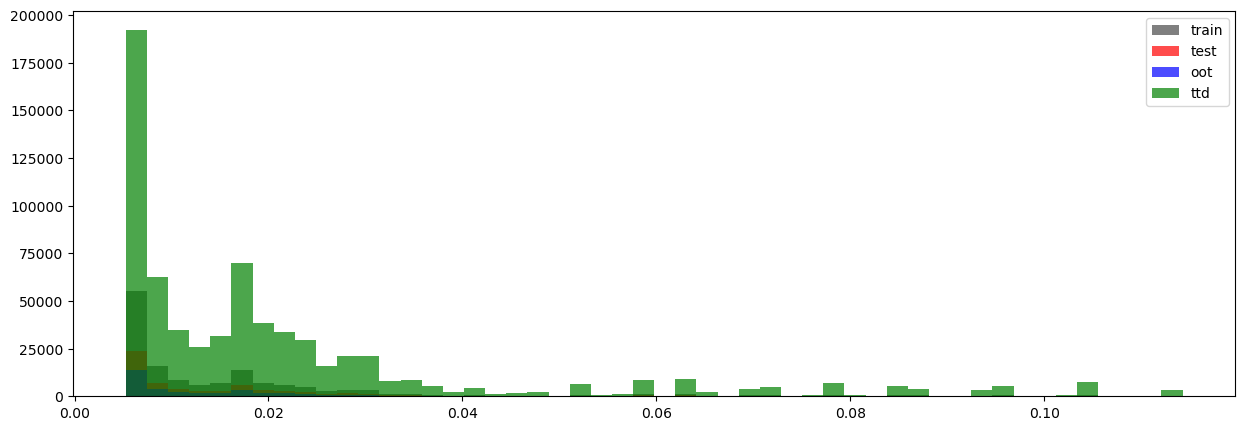

In [419]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [420]:
Train['p1'].value_counts(dropna= False).head()

p1
0.005289    12858
0.005929     5837
0.005857     5015
0.006586     3612
0.005875     3572
Name: count, dtype: int64

In [421]:
TTD['p1'].nunique()

1295

In [422]:
TTD['3_digit_score']= TTD['p1'].apply(lambda x: convert_to_3_digit(x))
TTD['3_digit_score'].describe()

count    685215.000000
mean        729.377874
std          35.756169
min         638.000000
25%         708.000000
50%         730.000000
75%         762.000000
max         776.000000
Name: 3_digit_score, dtype: float64

In [423]:
TTD['3_digit_score'].nunique()

122

In [113]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64


In [114]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [115]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
inquiryshortterm12month
sourcenonderogcount12month
assetpropevercount
inquirytelcom12month
sourcenonderogcount
derogcount
addrlastmovetaxratiodiff
inquirynonshortterm12month
addrcurrenttaxmarketvalue
addrinputtaxvalue
criminalnonfelonycount
evictioncount
derogcount12month
addrinputtimenewest
addrprevioustimeoldest
educationprogramattended
criminalfelonycount
educationattendance
addrinputlengthofres
addrcurrentblockratio
addrinputtaxmarketvalue
bankruptcydismissed24month
addrchangecount03month
inquirycollections12month
inquirybanking12month
bankruptcychapter
addrinputsubjectcount
addrchangecount24month
addrcurrentdeedmailing
addrinputdeedmailing
addrchangecount06month
lienjudgmentcount
lienjudgmentsmallclaimscount
addrpreviouslengthofres
bankruptcystatus
assetpropnewestmortgagetype
bankruptcycount24month
assetproppurchasetimeoldest
assetproppurchasetimenewest
criminalnonfelonycount12month
assetpersonalcount
addrchangecount60month
addrinputtimelastsale
a

In [116]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],1606.0,0.029652,0.030198,54162,691.0,0.029889,0.030367,23119.0,Yes
1,assetownership,[1],621.0,0.006700,0.008878,92693,268.0,0.006730,0.008884,39819.0,Yes
2,inquiryauto12month,[0],1496.0,0.011491,0.012411,130194,647.0,0.011612,0.012391,55716.0,Yes
3,inquiryauto12month,[1],731.0,0.043875,0.050581,16661,312.0,0.043201,0.050603,7222.0,Yes
4,inquiryshortterm12month,[0],2005.0,0.013959,0.016335,143630,882.0,0.014330,0.016383,61551.0,Yes
5,inquiryshortterm12month,[1],222.0,0.068837,0.034820,3225,77.0,0.055516,0.034190,1387.0,Yes
6,sourcenonderogcount12month,"[-inf, 2.0)",1730.0,0.023668,0.022178,73094,726.0,0.023263,0.022217,31209.0,Yes
7,sourcenonderogcount12month,"[2.0, inf)",497.0,0.006738,0.011353,73761,233.0,0.007343,0.011423,31729.0,Yes
8,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,0.030071,50788,663.0,0.030656,0.030245,21627.0,Yes
9,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,0.010104,51963,204.0,0.009101,0.010164,22414.0,Yes


In [117]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Tower
30041 572.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020352,0.114281,0.038002,6009,5708.0,301.0,5.01,20.0,19.37,52.62,33.25
1,0.012450,0.020352,0.016782,6008,5874.0,134.0,2.23,40.0,39.30,76.05,36.75
2,0.007291,0.012450,0.009073,6008,5926.0,82.0,1.36,60.0,59.41,90.38,30.97
3,0.005929,0.007291,0.006611,6008,5971.0,37.0,0.62,80.0,79.67,96.85,17.18
4,0.005289,0.005929,0.005621,6008,5990.0,18.0,0.30,100.0,100.00,100.00,0.00


{'Gini': 47.260000000000005, 'KS': 36.75}
GESA
19768 402.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025515,0.114281,0.047728,3954,3762.0,192.0,4.86,20.0,19.43,47.76,28.33
1,0.018111,0.025470,0.021408,3954,3855.0,99.0,2.50,40.0,39.33,72.39,33.06
2,0.009939,0.018111,0.014488,3953,3874.0,79.0,2.00,60.0,59.34,92.04,32.70
3,0.006565,0.009939,0.007827,3954,3929.0,25.0,0.63,80.0,79.62,98.26,18.64
4,0.005289,0.006565,0.005872,3953,3946.0,7.0,0.18,100.0,100.00,100.00,0.00


{'Gini': 45.09, 'KS': 33.06}
Hawaii
1438 3.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022412,0.114281,0.036891,288,287.0,1.0,0.35,20.03,20.00,33.33,13.33
1,0.018111,0.022412,0.019834,288,288.0,0.0,0.00,40.06,40.07,33.33,6.74
2,0.014709,0.018111,0.016151,287,286.0,1.0,0.35,60.01,60.00,66.67,6.67
3,0.008158,0.014709,0.009942,288,288.0,0.0,0.00,80.04,80.07,66.67,13.40
4,0.005289,0.008158,0.006914,287,286.0,1.0,0.35,100.00,100.00,100.00,0.00


{'Gini': -0.05, 'KS': 13.4}
Guardian
19177 268.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027018,0.114281,0.055309,3836,3698.0,138.0,3.60,20.0,19.56,51.49,31.93
1,0.018111,0.027018,0.021588,3835,3765.0,70.0,1.83,40.0,39.47,77.61,38.14
2,0.009095,0.018111,0.013383,3836,3801.0,35.0,0.91,60.0,59.57,90.67,31.10
3,0.006586,0.009095,0.007816,3835,3823.0,12.0,0.31,80.0,79.79,95.15,15.36
4,0.005289,0.006586,0.005935,3835,3822.0,13.0,0.34,100.0,100.00,100.00,0.00


{'Gini': 46.61, 'KS': 38.14}
SECU
12804 320.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024805,0.114281,0.051379,2561,2382.0,179.0,6.99,20.00,19.08,55.94,36.86
1,0.016469,0.024805,0.020178,2561,2487.0,74.0,2.89,40.00,39.00,79.06,40.06
2,0.008230,0.016469,0.012790,2561,2519.0,42.0,1.64,60.00,59.18,92.19,33.01
3,0.006505,0.008230,0.007046,2561,2541.0,20.0,0.78,80.01,79.53,98.44,18.91
4,0.005289,0.006505,0.005704,2560,2555.0,5.0,0.20,100.00,100.00,100.00,0.00


{'Gini': 51.54, 'KS': 40.06}
Arkansas
27867 167.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018443,0.114281,0.035048,5574,5481.0,93.0,1.67,20.0,19.79,55.69,35.90
1,0.009914,0.018443,0.014064,5573,5542.0,31.0,0.56,40.0,39.79,74.25,34.46
2,0.007250,0.009914,0.008296,5574,5553.0,21.0,0.38,60.0,59.84,86.83,26.99
3,0.005929,0.007250,0.006526,5573,5558.0,15.0,0.27,80.0,79.91,95.81,15.90
4,0.005289,0.005929,0.005482,5573,5566.0,7.0,0.13,100.0,100.00,100.00,0.00


{'Gini': 45.300000000000004, 'KS': 35.9}
Numerica
18091 297.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022483,0.114281,0.037682,3619,3488.0,131.0,3.62,20.0,19.60,44.11,24.51
1,0.014842,0.022483,0.018469,3618,3529.0,89.0,2.46,40.0,39.43,74.07,34.64
2,0.008230,0.014842,0.011047,3618,3575.0,43.0,1.19,60.0,59.53,88.55,29.02
3,0.006505,0.008230,0.007267,3618,3596.0,22.0,0.61,80.0,79.73,95.96,16.23
4,0.005289,0.006505,0.005868,3618,3606.0,12.0,0.33,100.0,100.00,100.00,0.00


{'Gini': 41.760000000000005, 'KS': 34.64}
CPM
6702 94.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019994,0.114281,0.037488,1341,1289.0,52.0,3.88,20.01,19.51,55.32,35.81
1,0.012252,0.019994,0.015894,1340,1320.0,20.0,1.49,40.00,39.48,76.60,37.12
2,0.007344,0.012252,0.009038,1341,1329.0,12.0,0.89,60.01,59.59,89.36,29.77
3,0.005929,0.007344,0.006644,1340,1333.0,7.0,0.52,80.01,79.77,96.81,17.04
4,0.005289,0.005929,0.005547,1340,1337.0,3.0,0.22,100.00,100.00,100.00,0.00


{'Gini': 47.9, 'KS': 37.12}
Bethpage
8328 63.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019177,0.114281,0.035890,1666,1642.0,24.0,1.44,20.00,19.87,38.10,18.23
1,0.014662,0.019177,0.016564,1666,1654.0,12.0,0.72,40.01,39.88,57.14,17.26
2,0.007250,0.014662,0.009990,1665,1650.0,15.0,0.90,60.00,59.84,80.95,21.11
3,0.005857,0.007250,0.006241,1666,1657.0,9.0,0.54,80.01,79.89,95.24,15.35
4,0.005289,0.005857,0.005363,1665,1662.0,3.0,0.18,100.00,100.00,100.00,0.00


{'Gini': 28.78, 'KS': 21.11}
HFCU
2044 33.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020273,0.114281,0.037406,409,397.0,12.0,2.93,20.01,19.74,36.36,16.62
1,0.014662,0.020273,0.017155,409,398.0,11.0,2.69,40.02,39.53,69.70,30.17
2,0.007344,0.014662,0.010305,409,402.0,7.0,1.71,60.03,59.52,90.91,31.39
3,0.005857,0.007344,0.006506,409,407.0,2.0,0.49,80.04,79.76,96.97,17.21
4,0.005289,0.005857,0.005408,408,407.0,1.0,0.25,100.00,100.00,100.00,0.00


{'Gini': 38.17, 'KS': 31.39}
NCU
595 8.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024140,0.114281,0.044797,120,115.0,5.0,4.17,20.17,19.59,62.5,42.91
1,0.016376,0.024137,0.019264,118,115.0,3.0,2.54,40.00,39.18,100.0,60.82
2,0.008230,0.016376,0.012805,120,120.0,0.0,0.00,60.17,59.63,100.0,40.37
3,0.005929,0.008230,0.007089,119,119.0,0.0,0.00,80.17,79.90,100.0,20.10
4,0.005289,0.005929,0.005545,118,118.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 65.72, 'KS': 60.82}


### Basic Checks

In [118]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(200148.0, 146855.0, 62938.0)

In [119]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [120]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((140153, 147), (140153, 147))

In [121]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((59995, 147), (59995, 147))

In [122]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [123]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    140153.000000
 mean          0.016828
 std           0.017377
 min           0.005289
 25%           0.006565
 50%           0.009939
 75%           0.020090
 max           0.114281
 Name: p1, dtype: float64,
 count    140153.000000
 mean          0.016828
 std           0.017377
 min           0.005289
 25%           0.006565
 50%           0.009939
 75%           0.020090
 max           0.114281
 Name: p1, dtype: float64)

In [124]:
Train['client'].value_counts(dropna= False)

client
Tower       30041
Arkansas    27867
GESA        19768
Guardian    19177
Numerica    18091
SECU        12804
Bethpage     8328
CPM          6702
HFCU         2044
Hawaii       1438
NCU           595
Name: count, dtype: int64

In [126]:
import datetime
pref= 'With_LDA'
Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [127]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [128]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,35333,2873.0,1857.0,126.0,0.040587
a.550-600,52785,13360.0,5376.0,346.0,0.035570
b.600-629,57138,23516.0,7940.0,386.0,0.030811
c.630-659,78628,39076.0,15179.0,554.0,0.026094
d.660-689,90338,52831.0,24815.0,511.0,0.021728
e.690-714,73120,48229.0,23877.0,300.0,0.018532
f.715-739,62889,45175.0,23083.0,186.0,0.016756
g.740+,199076,167515.0,93215.0,243.0,0.011987
h.Missing,35908,9030.0,4806.0,395.0,0.030600


In [129]:
TTD.shape

(685215, 148)

In [5]:
!ls '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'

050424_LN_Auto_KGB_LDA_No_Segment_Hopt_4.csv
With_LDA_Oot_Auto_LN_V2_Scored_Data_2024-04-08.csv
With_LDA_TTD_Auto_LN_V2_Scored_Data_2024-04-08.csv
With_LDA_Test_Auto_LN_V2_Scored_Data_2024-04-08.csv
With_LDA_Train_Auto_LN_V2_Scored_Data_2024-04-08.csv
xgbm_ln_auto_v2_hpt_best_with_lda_3.zip


In [6]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'
pref= 'With_LDA'
train_scored= pd.read_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_2024-04-08.csv')
train_scored.shape

(146855, 12)

In [7]:
train_scored['3_digit_score']= train_scored['p1'].apply(convert_to_3_digit)
train_scored['3_digit_score'].describe()

count    146855.000000
mean        739.241769
std          32.163494
min         638.000000
25%         718.000000
50%         748.000000
75%         767.000000
max         776.000000
Name: 3_digit_score, dtype: float64

In [48]:
def get_fico_distribution(x):
    return pd.DataFrame(x.describe([0.05*i for i in range(1, 20)] + [0.99])).T#.to_dict(orient= 'records')

In [20]:
train_scored['p1'].describe([0.25, 0.9, 0.95, 0.99])

count    146855.000000
mean          0.016741
std           0.017298
min           0.005289
25%           0.006565
50%           0.009939
90%           0.030474
95%           0.057923
99%           0.095058
max           0.114281
Name: p1, dtype: float64

In [22]:
temp= []
for sc in sorted(train_scored['3_digit_score'].unique(), reverse= True):
    a= {}
    a['3_digit_score']= sc
    a['apps']= len(train_scored[train_scored['3_digit_score']== sc])
    a['min_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].min()
    a['mean_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].mean()
    a['median_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].median()
    a['max_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].max()
    
    desc= train_scored[train_scored['3_digit_score']== sc]['fico_pb'].describe([0.25, 0.75, 0.9, 0.95, 0.99])
    a['apps_c']= desc['count']
    a['fico_mean']= desc['mean']
    a['fico_min']= desc['min']
    a['fico_25%']= desc['25%']
    a['fico_50%']= desc['50%']
    a['fico_75%']= desc['75%']
    a['fico_90%']= desc['90%']
    a['fico_95%']= desc['95%']
    a['fico_99%']= desc['99%']
    a['fico_max']= desc['max']
    
    temp.append(a)

In [23]:
temp= pd.DataFrame(temp)

In [26]:
temp

,3_digit_score,apps,min_pd,mean_pd,median_pd,max_pd,apps_c,fico_mean,fico_min,fico_25%,fico_50%,fico_75%,fico_90%,fico_95%,fico_99%,fico_max
0,776,12858,0.005289,0.005289,0.005289,0.005289,12854.0,768.140968,0.0,724.00,775.0,816.75,848.0,862.00,882.00,900.0
1,772,6688,0.005842,0.005853,0.005857,0.005857,6686.0,764.598564,0.0,719.00,772.0,814.00,842.0,861.00,881.00,900.0
2,771,9553,0.005875,0.005909,0.005929,0.005929,9552.0,762.366206,0.0,717.00,773.0,815.00,846.0,863.00,882.00,900.0
3,770,1298,0.006006,0.006006,0.006006,0.006006,1297.0,752.902853,0.0,708.00,756.0,805.00,836.4,855.40,874.04,892.0
4,767,7512,0.006468,0.006528,0.006548,0.006565,7511.0,757.255625,0.0,713.00,766.0,808.00,837.0,855.00,880.00,900.0
5,766,5510,0.006586,0.006607,0.006586,0.006708,5506.0,760.191246,0.0,714.00,773.0,812.75,841.0,860.00,882.00,900.0
6,765,768,0.006732,0.006732,0.006732,0.006732,766.0,733.552219,0.0,685.00,738.0,793.00,826.5,843.75,870.70,888.0
7,763,2922,0.007080,0.007096,0.007080,0.007196,2922.0,757.022245,0.0,712.00,762.0,806.00,835.0,850.00,872.79,892.0
8,762,6769,0.007220,0.007289,0.007285,0.007367,6767.0,750.916063,0.0,708.00,759.0,804.00,832.0,850.00,875.00,896.0
9,761,1908,0.007386,0.007444,0.007441,0.007518,1908.0,736.993187,0.0,695.75,747.0,797.00,825.0,842.00,872.00,888.0


In [49]:
temp_fico= list(train_scored.groupby('p1')['fico_pb'].apply(lambda x: get_fico_distribution(x)).reset_index().to_dict(orient= 'records'))

In [50]:
temp_fico= pd.DataFrame(temp_fico)
temp_fico.head()

,p1,level_1,count,mean,std,min,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,99%,max
0,0.005289,0.005289,12854.0,768.140968,67.849312,0.0,661.0,683.0,699.0,712.0,724.00,736.0,747.00,756.0,765.0,775.0,784.0,793.0,801.00,808.0,816.75,825.0,835.00,848.0,862.00,882.00,900.0
1,0.005842,0.005842,1673.0,761.711297,70.522221,0.0,658.6,680.0,693.0,705.0,716.00,728.0,740.00,751.8,761.0,772.0,781.0,789.0,796.80,804.0,811.00,818.0,826.00,835.8,852.00,879.56,900.0
2,0.005857,0.005857,5013.0,765.562138,67.425810,0.0,660.0,679.2,696.0,708.0,720.00,733.0,743.00,753.0,762.0,772.0,781.0,791.0,798.00,807.0,815.00,824.0,833.00,845.0,862.00,881.00,900.0
3,0.005875,0.005875,3571.0,764.692523,75.550047,0.0,654.0,682.0,697.0,710.0,723.00,734.0,745.00,754.0,764.0,774.0,784.0,793.0,801.00,808.0,815.00,823.0,831.00,840.0,860.00,880.00,895.0
4,0.005907,0.005907,144.0,783.826389,60.051299,609.0,671.3,700.0,715.7,729.6,745.75,753.0,765.05,776.2,786.0,794.5,804.0,811.0,816.95,821.0,831.25,837.0,842.65,851.0,862.85,883.13,891.0


In [51]:
temp_fico= temp_fico.sort_values(by= ['count'], ascending = False).reset_index(drop= True)

In [52]:
temp_fico.head(20)

,p1,level_1,count,mean,std,min,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,99%,max
0,0.005289,0.005289,12854.0,768.140968,67.849312,0.0,661.00,683.0,699.00,712.0,724.0,736.0,747.0,756.0,765.0,775.0,784.0,793.0,801.00,808.0,816.75,825.0,835.0,848.0,862.00,882.00,900.0
1,0.005929,0.005929,5837.0,760.413569,83.538153,0.0,646.00,672.0,688.00,702.0,714.0,726.0,738.0,750.0,760.0,771.0,780.8,789.0,798.00,807.0,814.00,824.0,834.0,848.0,864.20,883.00,900.0
2,0.005857,0.005857,5013.0,765.562138,67.425810,0.0,660.00,679.2,696.00,708.0,720.0,733.0,743.0,753.0,762.0,772.0,781.0,791.0,798.00,807.0,815.00,824.0,833.0,845.0,862.00,881.00,900.0
3,0.006586,0.006586,3609.0,765.342754,75.489219,0.0,647.00,672.0,688.00,703.0,716.0,730.0,744.0,758.0,770.0,780.0,789.0,797.0,805.00,810.0,817.00,826.0,834.0,847.0,864.00,883.92,900.0
4,0.005875,0.005875,3571.0,764.692523,75.550047,0.0,654.00,682.0,697.00,710.0,723.0,734.0,745.0,754.0,764.0,774.0,784.0,793.0,801.00,808.0,815.00,823.0,831.0,840.0,860.00,880.00,895.0
5,0.014842,0.014842,3327.0,672.389841,183.751984,0.0,0.00,599.0,629.00,648.0,661.0,672.0,682.0,692.0,701.0,710.0,720.0,730.0,741.00,751.0,761.00,774.0,787.1,803.0,819.00,849.48,892.0
6,0.016469,0.016469,2581.0,687.322356,153.868181,0.0,543.00,609.0,637.00,652.0,665.0,675.0,684.0,693.0,703.0,714.0,723.0,733.0,742.00,753.0,763.00,774.0,787.0,801.0,817.00,849.20,896.0
7,0.007080,0.007080,2463.0,758.544458,62.502786,490.0,653.00,675.0,690.00,702.0,714.0,724.0,734.0,744.0,754.9,763.0,771.0,781.0,789.00,798.0,807.00,816.0,826.0,838.0,852.00,873.00,892.0
8,0.018111,0.018111,2189.0,646.366834,209.544632,0.0,0.00,553.8,608.20,634.0,649.0,659.0,670.0,680.0,689.0,698.0,707.0,717.0,728.20,739.0,751.00,766.0,781.0,796.2,815.00,836.00,888.0
9,0.006565,0.006565,1811.0,757.948095,81.030733,0.0,647.00,672.0,686.00,699.0,712.0,723.0,736.0,746.0,757.0,767.0,777.0,786.0,794.00,803.0,810.00,819.0,830.0,842.0,862.00,880.00,900.0


In [ ]:
train_scored.groupby('p1').apply(
    lambda x: x.describe([0.05*i for i in range(1, 20)] + [0.99]
                        ).sort_values(by= 'funded_flag', ascending= False).head(20)